In [ ]:
!pip install matplotlib
!pip install scikit-image
!pip install pandas
!pip install opencv-python
!pip install albumentations
!pip install --upgrade typing_extensions
!pip install seaborn
!pip install scikit-learn
!pip install "numpy<2.0"

In [3]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import skimage
import random
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.core.composition import BboxParams, KeypointParams
from albumentations.pytorch import ToTensorV2
import os
import skimage.io
import skimage.io as io
import pandas as pd
from torch.nn.utils.rnn import pad_sequence 
import os
from sklearn.model_selection import train_test_split
from torch import optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_score, recall_score, f1_score
import pandas as pd
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.metrics import roc_auc_score, f1_score, jaccard_score
import pandas as pd
from datetime import datetime
import math as m
from scipy import ndimage
import math
from scipy.ndimage import map_coordinates
from scipy.ndimage import affine_transform, rotate
import sys
import logging
import json
import torch
import torch.nn as nn
from torchvision import models
from torch.nn.functional import relu
from torch.nn import Dropout
from torchvision.models.segmentation import deeplabv3_resnet50
from torch.optim.lr_scheduler import _LRScheduler
from torchvision.models.resnet import resnet50
from torch.optim.lr_scheduler import StepLR

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [6]:
torch.cuda.memory_summary()

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from large pool |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from small pool |      0 B   |      0 B   |      0 B   |      0 B   |\n|---------------------------------------------------------------------------|\n| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from large pool |      0 B   |      0 B   |

In [7]:
img_path_images_test = 'workspace/images/images'
img_path_labels_test = 'workspace/labels/ann'

In [8]:
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn
from torchvision import models
from torch.nn.functional import relu
import os
import shutil

In [9]:
class CollateFunction:
    def __init__(self, pad_idx=0):
        self.pad_idx = pad_idx

    
    def __call__(self, batch):
        images = [item[0] for item in batch]
        masks = [item[1] for item in batch]
        mask_weight = [item[2] for item in batch]
        white_pixs_array = [item[3] for item in batch]
        orig_image = [item[4] for item in batch]
        borders = [item[5] for item in batch]
        
        images = torch.stack(images, dim=0)
        masks = torch.stack(masks, dim=0)  # Stack masks the same way as images
        mask_weight = torch.stack(mask_weight, dim=0) 
        orig_image = torch.stack(orig_image, dim=0)
        

        return images, masks, mask_weight, white_pixs_array, orig_image, borders

In [10]:
class FiberDatasetMasks(Dataset):
    def __init__(self, images_dir, images, annotations_dir, crop_side, transform=None, train = True):
        self.images_dir = images_dir
        self.annotations_dir = annotations_dir
        self.transform = transform
        self.train = train
        self.images = images
        self.dataset_size = len(self.images)
        self.crop_side = crop_side
        self.crop_side_for_rot = int(np.ceil(self.crop_side * np.sqrt(2)))


    def __len__(self):
        # return len(self.images)
        if self.train:
            return int(1e6) # thats for infinite dataset...
        else:
            return len(self.images)
        
    def __getitem__(self, idx):

        actual_idx = idx % self.dataset_size
#         print("idx: \n", idx)
#         print("self.images[idx]: ", self.images[actual_idx])
        img_path = os.path.join(self.images_dir, self.images[actual_idx])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#         annotation_path = os.path.join(self.annotations_dir, self.images[actual_idx].replace('.bmp', '.txt'))
        annotation_path = os.path.join(self.annotations_dir, self.images[actual_idx].replace('.bmp', '.bmp.json'))
        keypoints = self.load_keypoints(annotation_path)
        img = img[:870,:1280,:]
    
        img = torch.from_numpy(img)
        img = img.permute(2, 0, 1)
        mask = self.create_mask_from_keypoints(img.shape, keypoints)
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)
    
        orig_image = img.clone()
        if np.where(mask > 0): 
            fiber_decision = random.choice(["yes","yes","yes","yes","yes","yes","yes","yes", "yes", "no",]) # 90%
#             print("fiber_decision: ", fiber_decision)
            if fiber_decision == "yes":
                try: # i need to have this try-except method because i cropped the image (img[:870,:,:]) and fiber could be there
                    white_pixs_array = self.sample_inside_fiber(mask, 1, only_inside_fiber=True)
#                     print("there is an asbestos")
                except ValueError:
                    white_pixs_array = self.sample_inside_fiber(mask, 1, only_inside_fiber=False)
            else:
                white_pixs_array = self.sample_inside_fiber(mask, 1, only_inside_fiber=False)
        else:
            white_pixs_array = self.sample_inside_fiber(mask, 1, only_inside_fiber=False)
            
            
        x_center, y_center = self.find_valid_patch_around_white_pixel(white_pixs_array, img.shape, (self.crop_side_for_rot, self.crop_side_for_rot))

        x0, x1, y0, y1 = self.calculate_patch_borders(x_center, y_center, (self.crop_side_for_rot, self.crop_side_for_rot), img.shape)


        x0_int = int(x0[0]) if isinstance(x0, np.ndarray) else int(x0)
        x1_int = int(x1[0]) if isinstance(x1, np.ndarray) else int(x1)
        y0_int = int(y0[0]) if isinstance(y0, np.ndarray) else int(y0)
        y1_int = int(y1[0]) if isinstance(y1, np.ndarray) else int(y1)


        patch = img[:, y0_int:y1_int, x0_int:x1_int]
        patch_mask = mask[:, y0_int:y1_int, x0_int:x1_int]
        

        rotation_decision = random.choice(["yes", "yes", "no", "no"]) # 50 % chance of being rotated
        if self.train and rotation_decision == "yes":
            angle = np.random.randint(low=0, high=360, size=1)[0]
        else:
            angle = 0

        img = self.patchmaker(patch, self.crop_side, self.crop_side, white_pixs_array = white_pixs_array, angle = angle)
#         print(f"np.max(img) :  {np.max(img)}, np.min(img) : {np.min(img)}")
        mask_final = self.patchmaker(patch_mask, self.crop_side, self.crop_side,white_pixs_array = white_pixs_array, angle = angle)

        
        if self.transform:
            transformed = self.transform(image=img, mask=mask_final)
            transformed_image = transformed['image']
            transformed_image = transformed_image[0].unsqueeze(0) # This selects the first channel
            transformed_mask = transformed['mask']
#             print("transformed_mask.shape: ", transformed_mask.shape)
#             print("transformed_image.shape: ", transformed_image.shape)
            transformed_mask = transformed_mask.permute(2, 0, 1)
 
        
        
        mask_weights = transformed_mask.clone()
        mask_weights = torch.where(mask_weights > 0.0, 1.0, 0.001)
#         print("mask_weights max: ", torch.max(mask_weights))
#         print("mask_weights min: ", torch.min(mask_weights))

        mask_final = transformed_mask

#         keypoints_flat = [kp for pair in keypoints for kp in pair]
#         keypoints_tensor = torch.tensor(keypoints_flat, dtype=torch.float32).view(-1, 2)
        
#         print("transformed_image min max: ", transformed_image.min(), transformed_image.max())
        image_crop = transformed_image.clone()
        transformed_image = transformed_image.float() 
        transformed_image_normalized = transformed_image / 255.0
        
        
        max_mask = torch.max(mask_final)
        if max_mask != 0.0:
            mask_final = mask_final.float() / max_mask
            mask_final = torch.clamp(mask_final, 0.0, 1.0)
            
        
        return transformed_image_normalized, mask_final, mask_weights, white_pixs_array, orig_image, (x0_int, x1_int, y0_int, y1_int)

    
    def load_keypoints(self, file_path):
        with open(file_path, 'r') as file:
            data = json.load(file)  

        keypoints_by_instance = {}

        for obj in data['objects']:
            object_id = obj['id']
            # Convert each exterior point pair to a tuple of floats
            coords = [(float(x), float(y)) for x, y in obj['points']['exterior']]

            # Save the coordinates for this object under its unique ID
            keypoints_by_instance[object_id] = coords

        return keypoints_by_instance
    

    
    def create_mask_from_keypoints(self,image_shape, keypoints):
        mask = np.zeros((image_shape[1], image_shape[2]), dtype=np.uint8)  

        for object_id, keypoints in keypoints.items():
            if len(keypoints) > 0:
                polygon = np.array(keypoints, np.int32).reshape((-1, 1, 2))
                if len(keypoints) > 2:
                    # Closed polygon if more than two points
                    cv2.fillPoly(mask, [polygon], color=255)
                else:
                    cv2.polylines(mask, [polygon], isClosed=False, color=255, thickness=3)
        return mask
    
    
    def sample_inside_fiber(self, mask, samples_amount, only_inside_fiber=True):
        if only_inside_fiber:
            # get elegible positive pixels
            white_pixs_pairs = np.where(mask > 0)
        else:
            # get any pair of pixels as center
            white_pixs_pairs = np.where(mask == 0)
        # sample N indices from elegible indicies
#         print("white_pixs_pairs: ", white_pixs_pairs)
        indices_sample = np.random.choice(len(white_pixs_pairs[0]), size = samples_amount, replace = False)
#         print("indices_sample: ", indices_sample)
        # get center coords using sampled indices
        centers_array = np.array(white_pixs_pairs)[:, indices_sample]

        return centers_array
    
    def valid_patch(self, x0, x1, y0, y1 ,img_shape):

        condition = (x0 >= 0) & (y0 >= 0) & (x1 <= img_shape[2]) & (y1 <= img_shape[1])
#         print(f"condition: {condition} ")

        return condition
    
    
    
    def calculate_patch_borders(self, x_center, y_center, patch_size, img_shape):
        # Define a margin to keep x_center and y_center away from the patch's edges
        margin = 3  # Adjust based on your needs

        # Maximum allowable coordinates for the top-left corner of the patch
        max_x0 = img_shape[2] - patch_size[0]
        max_y0 = img_shape[1] - patch_size[1]

        # Minimum allowable coordinates for the top-left corner of the patch
        min_x0 = 0
        min_y0 = 0

        # Calculate the range within which the top-left corner can be chosen
        # Apply margin to ensure x_center and y_center are not too close to the edges
        x0_range_min = max(min_x0, x_center - patch_size[0] + margin)
        x0_range_max = min(max_x0, x_center - margin)

        y0_range_min = max(min_y0, y_center - patch_size[1] + margin)
        y0_range_max = min(max_y0, y_center - margin)

        # Ensure the min value is less than the max value, if not, adjust
        # This is a simplistic fix and might need refinement based on exact requirements
        if x0_range_min >= x0_range_max:
            x0_range_min, x0_range_max = x_center - patch_size[0] // 2, x_center + patch_size[0] // 2
            if x0_range_max > max_x0:  # Adjust if exceeding image dimensions
                x0_range_max = max_x0
                x0_range_min = max_x0 - patch_size[0]
        if y0_range_min >= y0_range_max:
            y0_range_min, y0_range_max = y_center - patch_size[1] // 2, y_center + patch_size[1] // 2
            if y0_range_max > max_y0:  # Adjust if exceeding image dimensions
                y0_range_max = max_y0
                y0_range_min = max_y0 - patch_size[1]

        # Randomly select the top-left corner from the allowable range
        x0 = np.random.randint(x0_range_min, x0_range_max)
        y0 = np.random.randint(y0_range_min, y0_range_max)

        # Calculate the bottom-right corner based on the top-left corner and patch size
        x1 = x0 + patch_size[0]
        y1 = y0 + patch_size[1]

        # Ensure the patch is within the image boundaries
        x0, x1 = max(0, x0), min(img_shape[2], x1)
        y0, y1 = max(0, y0), min(img_shape[1], y1)

        return (x0, x1, y0, y1)



    
    def find_valid_patch_around_white_pixel(self, white_pixs_array, img_shape, patch_size):
        # Randomly shuffle the array of white pixel coordinates
        x_center, y_center = white_pixs_array[2], white_pixs_array[1]
        
#         print(f"x_center: {x_center},  y_center: {y_center}, patch_size: {patch_size}")
        x0, x1, y0, y1 = self.calculate_patch_borders(x_center, y_center, patch_size, img_shape)
#         print(f"x0: {x0},  x1: {x1}, y0: {y0}, y1: {y1}")
        if self.valid_patch(x0, y0, x1, y1, img_shape):
            return x_center, y_center  # Return the first valid patch center found
        else:
            return None, None  # Return None if no valid patch found

        

    
    def patchmaker(self, img_tensor, height, width, white_pixs_array, angle, margin=4):
        # Convert from PyTorch tensor to numpy array and handle channel order
        img = img_tensor.numpy()
        if img.ndim == 3:
            img = img.transpose(1, 2, 0)  # Transpose to H x W x C
    
        # Extracting fiber coordinates
        x_fiber, y_fiber = int(white_pixs_array[2][0]), int(white_pixs_array[1][0])
    
        # Calculate center for rotation (center of the image)
        image_center = np.array([img.shape[1] // 2, img.shape[0] // 2])
    
        # Interpolation order
        if img.shape[2] == 1:
            order = 0  # Nearest neighbor for masks
        else:
            order = 3  # Bicubic for images
    
        # Rotating the entire image
        rotated_img = rotate(img, angle, reshape=False, order=order, mode='wrap', cval=0, axes=(1, 0), prefilter=True)
    
        # Calculate new fiber coordinates after rotation
        angle_rad = -np.radians(angle)  # Convert angle to radians
        rotation_matrix = np.array([[np.cos(angle_rad), -np.sin(angle_rad)],
                                    [np.sin(angle_rad), np.cos(angle_rad)]])
    
        relative_coords = np.array([x_fiber, y_fiber]) - image_center
        new_coords = rotation_matrix @ relative_coords + image_center
        new_x, new_y = int(new_coords[0]), int(new_coords[1])
    
        # Ensure that the fiber coordinates are within the patch bounds
        x0 = max(margin, min(rotated_img.shape[1] - width - margin, new_x - width // 2))
        y0 = max(margin, min(rotated_img.shape[0] - height - margin, new_y - height // 2))
        x1 = x0 + width
        y1 = y0 + height
    
        # Adjust patch to include fiber coordinates if necessary
        if new_x < x0:
            x0 = max(margin, new_x - width // 2)
        elif new_x >= x1:
            x0 = min(rotated_img.shape[1] - width - margin, new_x - width // 2)
    
        if new_y < y0:
            y0 = max(margin, new_y - height // 2)
        elif new_y >= y1:
            y0 = min(rotated_img.shape[0] - height - margin, new_y - height // 2)
    
        x1 = x0 + width
        y1 = y0 + height
    
        # Ensure patch is within image bounds
        x0 = max(margin, min(rotated_img.shape[1] - width - margin, x0))
        y0 = max(margin, min(rotated_img.shape[0] - height - margin, y0))
    
        x1 = x0 + width
        y1 = y0 + height
    
        # Extract the patch
        patch = rotated_img[y0:y1, x0:x1]
    
        # Verify and enforce the patch size is exactly as expected
        final_patch = np.zeros((height, width, img.shape[2]), dtype=patch.dtype)
        patch_height, patch_width, _ = patch.shape
        final_patch[:patch_height, :patch_width] = patch
    
        # # Check if the fiber coordinates are within the patch
        # if x0 <= new_x < x1 and y0 <= new_y < y1:
        #     print(f"Fiber coordinates ({new_x}, {new_y}) are within the patch.")
        # else:
        #     print(f"Fiber coordinates ({new_x}, {new_y}) are NOT within the patch.")
    
        return final_patch
    


transform_train = A.Compose([
#     A.Rotate(limit=360, p=0.5),
    A.HorizontalFlip(p=0.5),
#     A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.5),
    A.RandomGamma(gamma_limit=(80, 120), p=0.5),
    A.CoarseDropout(max_holes=4, max_height=16, max_width=16, min_holes=1, min_height=16, min_width=16, fill_value=0, p=0.5),
#     A.RandomScale(scale_limit=0.2, p=0.5),
#     A.Resize(height=480, width=640),
    # A.GaussNoise(var_limit=(10, 50), p=0.2),
    # A.RandomGridShuffle(grid=(2, 2), p=0.2),
#     A.CLAHE(clip_limit=2.0, p=0.5),
    ToTensorV2()
])

transform_test = A.Compose([
#     A.Resize(height=480, width=640),
    ToTensorV2()
])


    


In [11]:
images = [img for img in os.listdir(img_path_images_test) if img.endswith('.bmp') and img != 'SEI-Slow-1280x960-10_Sec_581None.bmp']
labels = [lab for lab in os.listdir(img_path_labels_test) if lab.endswith('.json')]
# # [img for img in os.listdir(images_dir) if img.endswith('.bmp')]
train_images, test_images = train_test_split(images, test_size=0.2, random_state=15)

In [12]:
len(train_images)

750

In [13]:
len(test_images)

188

In [14]:
img_path_labels_test

'workspace/labels/ann'

In [15]:
collate_fn = CollateFunction(pad_idx=0)
dataset_train = FiberDatasetMasks(images_dir=img_path_images_test, images = train_images, annotations_dir=img_path_labels_test, crop_side = 256,transform = transform_train, train=True)
dataloader_train = DataLoader(dataset_train, batch_size=30, shuffle=True, collate_fn = CollateFunction(pad_idx=0))

dataset_test = FiberDatasetMasks(images_dir=img_path_images_test, images = test_images, annotations_dir=img_path_labels_test, crop_side = 256, transform = transform_test, train=False)
dataloader_test = DataLoader(dataset_test, batch_size=30, shuffle=False, collate_fn = CollateFunction(pad_idx=0))


In [16]:

# Iterate over the dataset
iter = 0
for img, mask, mask_weight, white_pixs_array, orig_image, borders in dataloader_train:

        print("img.shape", img.shape )
#         img = img.float() / 255.0
        print(torch.max(img), torch.min(img))
#         mask = mask.float() / 255
#         mask = torch.clamp(mask, 0.0, 1.0)
        print(torch.max(mask), torch.min(mask))
        
        
        print("mask.shape: ", mask.shape)
#         print("mask_weight.shape: ", mask_weight.shape)
        print("mask_weight.shape", mask_weight.shape)
        print("mask_weight", mask_weight[0])
        count_ones = (mask_weight == 1).sum().item()
        count_zero_point_ones = (mask_weight == 0.001).sum().item()
    
        print("Count of 1s:", count_ones)
        print("Count of 0s:", count_zero_point_ones)
        print(count_ones / count_zero_point_ones)
#         print("mask.min() after norm: ", mask.min())
#         print("mask.max() after norm: ", mask.max())
#         print("orig_image.shape: ", orig_image.shape)
#         print("borders: ", borders)
        break



img.shape torch.Size([30, 1, 256, 256])
tensor(1.) tensor(0.)
tensor(1.) tensor(0.)
mask.shape:  torch.Size([30, 1, 256, 256])
mask_weight.shape torch.Size([30, 1, 256, 256])
mask_weight tensor([[[0.0010, 0.0010, 0.0010,  ..., 0.0010, 0.0010, 0.0010],
         [0.0010, 0.0010, 0.0010,  ..., 0.0010, 0.0010, 0.0010],
         [0.0010, 0.0010, 0.0010,  ..., 0.0010, 0.0010, 0.0010],
         ...,
         [0.0010, 0.0010, 0.0010,  ..., 0.0010, 0.0010, 0.0010],
         [0.0010, 0.0010, 0.0010,  ..., 0.0010, 0.0010, 0.0010],
         [0.0010, 0.0010, 0.0010,  ..., 0.0010, 0.0010, 0.0010]]])
Count of 1s: 5419
Count of 0s: 1960661
0.002763863819395602


In [1]:
import matplotlib.pyplot as plt

def draw_red_square(image, center_y, center_x, size=3, color=[255, 0, 0]):
    """Draws a square of a given size and color around a center point in the image."""
    half_size = size // 2
    y_start, y_end = max(0, center_y - half_size), min(image.shape[0], center_y + half_size + 1)
    x_start, x_end = max(0, center_x - half_size), min(image.shape[1], center_x + half_size + 1)
    image[y_start:y_end, x_start:x_end, :] = color
    return image  # Optionally return the modified image


def draw_blue_rectangle(image, x0, x1, y0, y1, border_thickness=3, color=[0, 0, 255]):
    # Ensure coordinates are integers
    x0, x1, y0, y1 = map(int, [x0, x1, y0, y1])
    
    # Draw top and bottom borders
    image[y0:y0+border_thickness, x0:x1] = color
    image[y1-border_thickness:y1, x0:x1] = color

    # Draw left and right borders
    image[y0:y1, x0:x0+border_thickness] = color
    image[y0:y1, x1-border_thickness:x1] = color

    return image


iter = 0
for img, mask, mask_weight, white_pixs_array, orig_image, borders in dataloader_train:

    if iter == 1:
        break
    print("Iter: ", iter)
    print("img.dtype: ", img.dtype)
    print("images.shape in the loop: ", img.shape)
    print("Image norm max min", torch.max(img), torch.min(img))
    print("mask.shape in the loop", mask.shape)

    count_ones = (mask_weight == 1).sum().item()
    count_zero_point_ones = (mask_weight == 0.1).sum().item()
    
    
    # print("img_test.shape: ",img_test.shape)
    
    img = img.to(device, dtype=torch.float)
    
    mask = mask.to(device, dtype=torch.float)
    


    for i in range(img.shape[0]):
        im = img[i].cpu().numpy().transpose(1, 2, 0) #.astype(int)

        if torch.is_tensor(orig_image[i]):
            orig_image_numpy = orig_image[i].numpy()
        else:
            # It's already a numpy array or another type that doesn't support .numpy()
            orig_image_numpy = orig_image[i]

        
        y = int(white_pixs_array[i][1][0])
        x = int(white_pixs_array[i][2][0])
        color = [255, 0, 0] 

        x0, x1, y0, y1 = borders[i]

        orig_image_modified = draw_red_square(orig_image_numpy.transpose(1, 2, 0).astype(np.uint8), y, x, size=10)

        orig_image_with_blue_rectangle = draw_blue_rectangle(orig_image_modified, x0, x1, y0, y1, border_thickness=3)


        ma = mask[i].cpu().numpy().transpose(1, 2, 0) #.astype(int)
        
        print("im.shape: ", im.shape)
        print("ma.shape: ", ma.shape)

        image_rgb = im

        print(f"Picture number {i}")

        plt.figure(figsize=(8, 6))
        plt.imshow(orig_image_with_blue_rectangle, cmap='gray') 
        plt.title('Orig_image', fontsize=15)
        plt.axis('off') 



        plt.show()
        
        plt.figure(figsize=(10, 8))
        

        plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
        plt.imshow(image_rgb, cmap='gray')
        plt.title('Transformed Image normalized', fontsize=15)
        plt.axis('off')  

        # Plot the mask
        plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
        plt.imshow(ma, cmap='gray') 
        plt.title('Mask transformed', fontsize=15)
        plt.axis('off') 

        plt.show()



        # plt.show()
        print("-------------")
    iter += 1



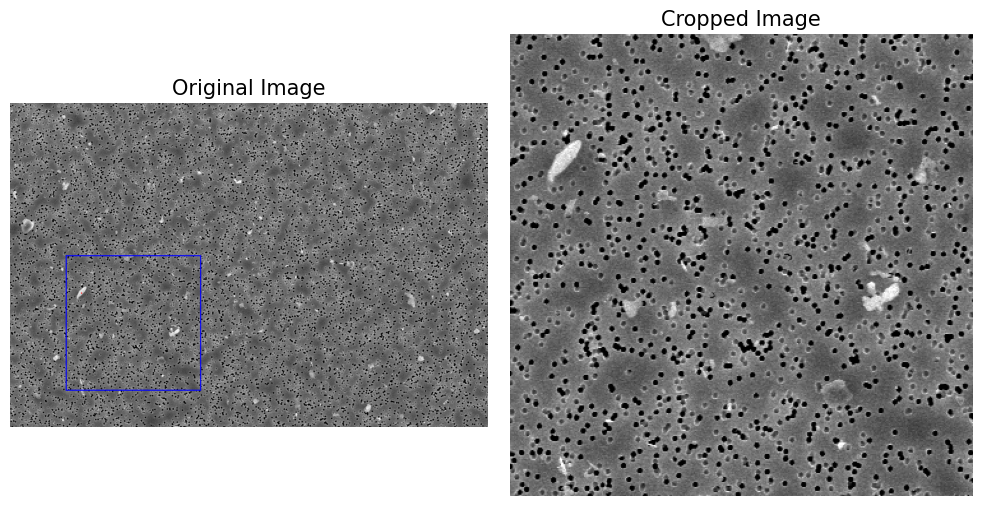

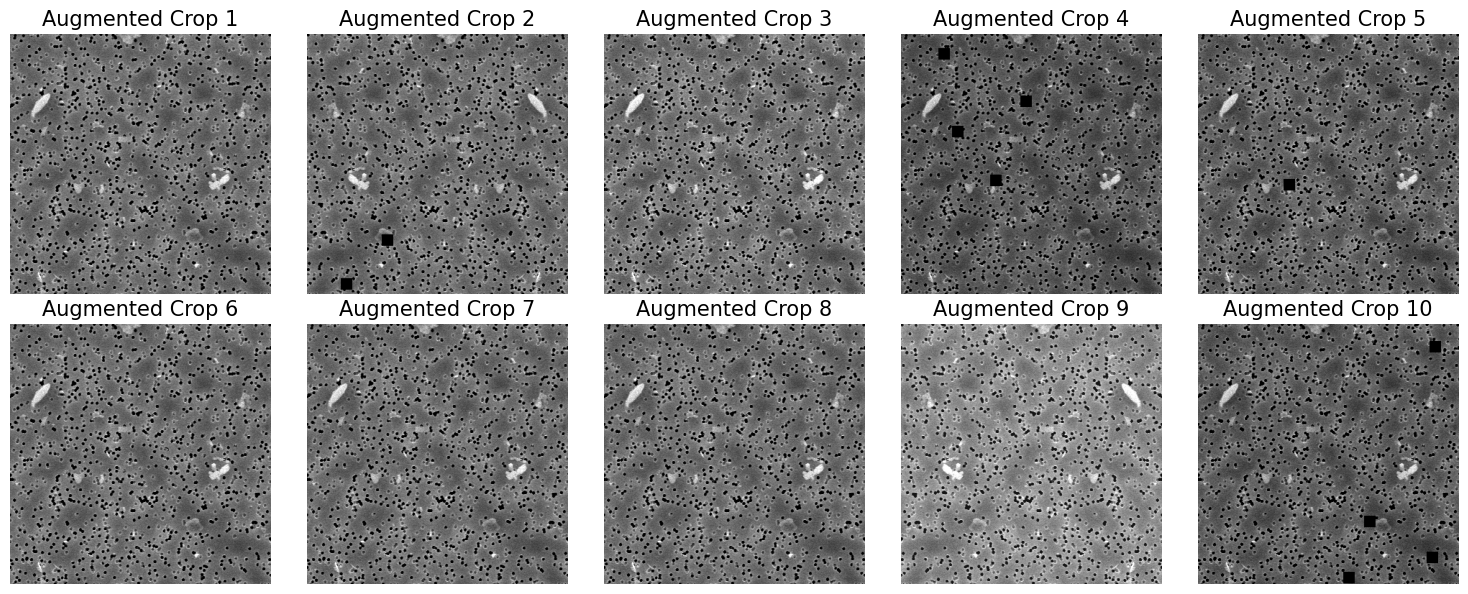

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2


# Function to plot original image and cropped image
def plot_original_and_crop(orig_image, crop, center_y, center_x, x0, x1, y0, y1):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    
    # Plot original image with red square and blue rectangle
    orig_img_with_rect = draw_red_square(orig_image.copy(), center_y, center_x)
    orig_img_with_rect = draw_blue_rectangle(orig_img_with_rect, x0, x1, y0, y1)
    axs[0].imshow(orig_img_with_rect)
    axs[0].set_title('Original Image', fontsize=15)
    axs[0].axis('off')
    
    # Plot cropped image
    axs[1].imshow(crop)
    axs[1].set_title('Cropped Image', fontsize=15)
    axs[1].axis('off')
    
    plt.tight_layout()
    plt.show()

# Function to plot augmented crops
def plot_augmented_crops(augmented_crops):
    fig, axs = plt.subplots(2, 5, figsize=(15, 6))
    
    # Plot augmented crops
    for i, aug_crop in enumerate(augmented_crops):
        row = i // 5
        col = i % 5
        axs[row, col].imshow(aug_crop)
        axs[row, col].set_title(f'Augmented Crop {i+1}', fontsize=15)
        axs[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()

# Define augmentation pipeline
augment_pipeline = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.5),
    A.RandomGamma(gamma_limit=(80, 120), p=0.5),
    A.CoarseDropout(max_holes=4, max_height=16, max_width=16, min_holes=1, min_height=16, min_width=16, fill_value=0, p=0.5)
])

# Generate and plot augmented crops for the first image in the dataloader
for img, mask, mask_weight, white_pixs_array, orig_image, borders in dataloader_train:
    # Assuming you are only using the first image in the batch for demonstration
    orig_img = orig_image[0].numpy().transpose(1, 2, 0).astype(np.uint8)
    
    center_y, center_x = int(white_pixs_array[0][1][0]), int(white_pixs_array[0][2][0])
    x0, x1, y0, y1 = borders[0]
    
    # Generate crop from the original image
    crop = orig_img[y0:y1, x0:x1]
    
    # Ensure crop is in the correct color space (RGB)
    if crop.shape[2] == 1:  # In case it's grayscale
        crop = np.repeat(crop, 3, axis=2)
    
    # Plot the original image and cropped image
    plot_original_and_crop(orig_img, crop, center_y, center_x, x0, x1, y0, y1)
    
    # Apply augmentations
    augmented_crops = []
    for _ in range(10):
        augmented = augment_pipeline(image=crop)['image']
        augmented_crops.append(augmented)
    
    # Plot augmented crops
    plot_augmented_crops(augmented_crops)
    break


In [19]:
#without Relu on last block 
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        
        def double_conv(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            )
        
        self.down1 = double_conv(in_channels, 64)
        self.down2 = double_conv(64, 128)
        self.down3 = double_conv(128, 256)
        self.down4 = double_conv(256, 512)
        self.down5 = double_conv(512, 1024)
        
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.up4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.up_conv4 = double_conv(1024, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.up_conv3 = double_conv(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.up_conv2 = double_conv(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        
        # This block does not have activation functions (ReLU)
        self.up_conv1 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.Conv2d(64, 64, kernel_size=3, padding=1)
        )
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)
    
    def forward(self, x):
        # Downsample
        d1 = self.down1(x)
        d2 = self.maxpool(d1)
        d2 = self.down2(d2)
        d3 = self.maxpool(d2)
        d3 = self.down3(d3)
        d4 = self.maxpool(d3)
        d4 = self.down4(d4)
        d5 = self.maxpool(d4)
        d5 = self.down5(d5)
        
        # Upsample
        u4 = self.up4(d5)
        u4 = torch.cat((d4, u4), dim=1)
        u4 = self.up_conv4(u4)
        u3 = self.up3(u4)
        u3 = torch.cat((d3, u3), dim=1)
        u3 = self.up_conv3(u3)
        u2 = self.up2(u3)
        u2 = torch.cat((d2, u2), dim=1)
        u2 = self.up_conv2(u2)
        u1 = self.up1(u2)
        u1 = torch.cat((d1, u1), dim=1)
        u1 = self.up_conv1(u1)
        
        out = self.final_conv(u1)
        return out

In [30]:
model = UNet(in_channels=1, out_channels=1) 
total_params = sum(p.numel() for p in model.parameters())
print(f'Total number of parameters: {total_params}')

Total number of parameters: 31030593


In [23]:
# reduced by 4

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        
        def double_conv(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            )
        
        self.down1 = double_conv(in_channels, 16)  # 64/4
        self.down2 = double_conv(16, 32)  # 128/4
        self.down3 = double_conv(32, 64)  # 256/4
        self.down4 = double_conv(64, 128)  # 512/4
        self.down5 = double_conv(128, 256)  # 1024/4
        
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.up4 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)  # 1024/4 -> 512/4
        self.up_conv4 = double_conv(256, 128)  # 1024/4 -> 512/4
        self.up3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)  # 512/4 -> 256/4
        self.up_conv3 = double_conv(128, 64)  # 512/4 -> 256/4
        self.up2 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)  # 256/4 -> 128/4
        self.up_conv2 = double_conv(64, 32)  # 256/4 -> 128/4
        self.up1 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)  # 128/4 -> 64/4
        
        # This block does not have activation functions (ReLU)
        self.up_conv1 = nn.Sequential(
            nn.Conv2d(32, 16, kernel_size=3, padding=1),  # 128/4 -> 64/4
            nn.Conv2d(16, 16, kernel_size=3, padding=1)   # 64/4
        )
        self.final_conv = nn.Conv2d(16, out_channels, kernel_size=1)  # 64/4
    
    def forward(self, x):
        # Downsample
        d1 = self.down1(x)
        d2 = self.maxpool(d1)
        d2 = self.down2(d2)
        d3 = self.maxpool(d2)
        d3 = self.down3(d3)
        d4 = self.maxpool(d3)
        d4 = self.down4(d4)
        d5 = self.maxpool(d4)
        d5 = self.down5(d5)
        
        # Upsample
        u4 = self.up4(d5)
        u4 = torch.cat((d4, u4), dim=1)
        u4 = self.up_conv4(u4)
        u3 = self.up3(u4)
        u3 = torch.cat((d3, u3), dim=1)
        u3 = self.up_conv3(u3)
        u2 = self.up2(u3)
        u2 = torch.cat((d2, u2), dim=1)
        u2 = self.up_conv2(u2)
        u1 = self.up1(u2)
        u1 = torch.cat((d1, u1), dim=1)
        u1 = self.up_conv1(u1)
        
        out = self.final_conv(u1)
        return out


In [24]:
model = UNet(in_channels=1, out_channels=1) 
total_params = sum(p.numel() for p in model.parameters())
print(f'Total number of parameters: {total_params}')

Total number of parameters: 1940817


In [25]:
#reduced by 8

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        
        def double_conv(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            )
        
        self.down1 = double_conv(in_channels, 8)  # 64/8
        self.down2 = double_conv(8, 16)  # 128/8
        self.down3 = double_conv(16, 32)  # 256/8
        self.down4 = double_conv(32, 64)  # 512/8
        self.down5 = double_conv(64, 128)  # 1024/8
        
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.up4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)  # 1024/8 -> 512/8
        self.up_conv4 = double_conv(128, 64)  # 1024/8 -> 512/8
        self.up3 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)  # 512/8 -> 256/8
        self.up_conv3 = double_conv(64, 32)  # 512/8 -> 256/8
        self.up2 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)  # 256/8 -> 128/8
        self.up_conv2 = double_conv(32, 16)  # 256/8 -> 128/8
        self.up1 = nn.ConvTranspose2d(16, 8, kernel_size=2, stride=2)  # 128/8 -> 64/8
        
        # This block does not have activation functions (ReLU)
        self.up_conv1 = nn.Sequential(
            nn.Conv2d(16, 8, kernel_size=3, padding=1),  # 128/8 -> 64/8
            nn.Conv2d(8, 8, kernel_size=3, padding=1)   # 64/8
        )
        self.final_conv = nn.Conv2d(8, out_channels, kernel_size=1)  # 64/8
    
    def forward(self, x):
        # Downsample
        d1 = self.down1(x)
        d2 = self.maxpool(d1)
        d2 = self.down2(d2)
        d3 = self.maxpool(d2)
        d3 = self.down3(d3)
        d4 = self.maxpool(d3)
        d4 = self.down4(d4)
        d5 = self.maxpool(d4)
        d5 = self.down5(d5)
        
        # Upsample
        u4 = self.up4(d5)
        u4 = torch.cat((d4, u4), dim=1)
        u4 = self.up_conv4(u4)
        u3 = self.up3(u4)
        u3 = torch.cat((d3, u3), dim=1)
        u3 = self.up_conv3(u3)
        u2 = self.up2(u3)
        u2 = torch.cat((d2, u2), dim=1)
        u2 = self.up_conv2(u2)
        u1 = self.up1(u2)
        u1 = torch.cat((d1, u1), dim=1)
        u1 = self.up_conv1(u1)
        
        out = self.final_conv(u1)
        return out


In [26]:
model = UNet(in_channels=1, out_channels=1) 
total_params = sum(p.numel() for p in model.parameters())
print(f'Total number of parameters: {total_params}')

Total number of parameters: 485673


In [27]:
#reduced by 2

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        
        def double_conv(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            )
        
        self.down1 = double_conv(in_channels, 32)  # 64/2
        self.down2 = double_conv(32, 64)  # 128/2
        self.down3 = double_conv(64, 128)  # 256/2
        self.down4 = double_conv(128, 256)  # 512/2
        self.down5 = double_conv(256, 512)  # 1024/2
        
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.up4 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)  # 1024/2 -> 512/2
        self.up_conv4 = double_conv(512, 256)  # 1024/2 -> 512/2
        self.up3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)  # 512/2 -> 256/2
        self.up_conv3 = double_conv(256, 128)  # 512/2 -> 256/2
        self.up2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)  # 256/2 -> 128/2
        self.up_conv2 = double_conv(128, 64)  # 256/2 -> 128/2
        self.up1 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)  # 128/2 -> 64/2
        
        # This block does not have activation functions (ReLU)
        self.up_conv1 = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=3, padding=1),  # 128/2 -> 64/2
            nn.Conv2d(32, 32, kernel_size=3, padding=1)   # 64/2
        )
        self.final_conv = nn.Conv2d(32, out_channels, kernel_size=1)  # 64/2
    
    def forward(self, x):
        # Downsample
        d1 = self.down1(x)
        d2 = self.maxpool(d1)
        d2 = self.down2(d2)
        d3 = self.maxpool(d2)
        d3 = self.down3(d3)
        d4 = self.maxpool(d3)
        d4 = self.down4(d4)
        d5 = self.maxpool(d4)
        d5 = self.down5(d5)
        
        # Upsample
        u4 = self.up4(d5)
        u4 = torch.cat((d4, u4), dim=1)
        u4 = self.up_conv4(u4)
        u3 = self.up3(u4)
        u3 = torch.cat((d3, u3), dim=1)
        u3 = self.up_conv3(u3)
        u2 = self.up2(u3)
        u2 = torch.cat((d2, u2), dim=1)
        u2 = self.up_conv2(u2)
        u1 = self.up1(u2)
        u1 = torch.cat((d1, u1), dim=1)
        u1 = self.up_conv1(u1)
        
        out = self.final_conv(u1)
        return out


In [28]:
model = UNet(in_channels=1, out_channels=1) 
total_params = sum(p.numel() for p in model.parameters())
print(f'Total number of parameters: {total_params}')

Total number of parameters: 7759521


In [20]:
class CombinedSoftDiceBCELoss(nn.Module): # combined loss binary_cross_entropy_with_logits and soft dice loss
    def __init__(self, smooth=1, weight_bce=0.5, weight_dice=0.5):
        super(CombinedSoftDiceBCELoss, self).__init__()
        self.smooth = smooth
        self.weight_bce = weight_bce
        self.weight_dice = weight_dice

    def forward(self, inputs, targets, weight=None):
        # Compute BCE loss
        if weight is not None:
            bce_loss = F.binary_cross_entropy_with_logits(inputs, targets, weight=weight)
        else:
            bce_loss = F.binary_cross_entropy_with_logits(inputs, targets)

        # Apply sigmoid to get probabilities
        inputs = torch.sigmoid(inputs)
        
        # Flatten the inputs and targets for dice loss calculation
        inputs_flat = inputs.view(-1)
        targets_flat = targets.view(-1)

        # Compute Soft Dice loss
        intersection = (inputs_flat * targets_flat).sum()
        dice_loss = 1 - (2. * intersection + self.smooth) / (inputs_flat.sum() + targets_flat.sum() + self.smooth)
        
        # Combine the two losses
        combined_loss = self.weight_bce * bce_loss + self.weight_dice * dice_loss
        return combined_loss

In [21]:
criterion = CombinedSoftDiceBCELoss(weight_bce=0.5, weight_dice=0.5)
# criterion = DiceLoss()

In [22]:
# len(dataset_test.images)

In [23]:
actual_dataset_size = len(dataset_train.images)  # Use the actual number of images in the dataset
batch_size = 30
batches_per_epoch = actual_dataset_size // batch_size
if actual_dataset_size % batch_size != 0:
    batches_per_epoch += 1  # Ensure the last batch is accounted for

In [24]:
actual_dataset_size

750

In [25]:
batches_per_epoch

25

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = UNet(in_channels=1, out_channels=1).to(device)

# model = DeepLabV3(num_classes=1).to(device)

# optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# scheduler = StepLR(optimizer, step_size=60, gamma=0.1)

# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# scheduler_each_epoch = ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=15, min_lr=1e-6) ## instead of this
scheduler_each_batch = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, 
    max_lr=0.0001, 
    steps_per_epoch=batches_per_epoch, 
    epochs=200,
    anneal_strategy='linear',
    final_div_factor = 10 
)


In [28]:
torch.cuda.empty_cache()

In [29]:
torch.cuda.memory_summary()

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      | 123135 KiB | 123135 KiB | 138495 KiB |  15360 KiB |\n|       from large pool | 120448 KiB | 120448 KiB | 135808 KiB |  15360 KiB |\n|       from small pool |   2687 KiB |   2687 KiB |   2687 KiB |      0 KiB |\n|---------------------------------------------------------------------------|\n| Active memory         | 123135 KiB | 123135 KiB | 138495 KiB |  15360 KiB |\n|       from large pool | 120448 KiB | 120448 KiB |

In [30]:
models_save_path = "workspace/models/18_07_2024_BCE_dice_50_50_learning_rate_onecycle_1/"

if not os.path.exists(models_save_path):
    os.makedirs(models_save_path)

In [31]:
batches_per_epoch

25

In [31]:
# criterion = SoftDiceLoss()

In [33]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.metrics import roc_auc_score, f1_score, jaccard_score
import pandas as pd
from datetime import datetime


losses_train = []
losses_val = []
epoch_list = []
losses_dice = []
dice_list = []
learning_rates_batches = []
learning_rates_epochs = []


def validate(model, dataloader_test, device, batches_per_epoch): #use_bce
    model.eval()
    total_val_loss = 0
    # total_dice_score = 0
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for batch_idx, (img, mask, weights, _, _, _) in enumerate(dataloader_test):
            if len(dataset_test.images) % batch_size != 0:
                batches_per_epoch_eval = len(dataset_test.images) // batch_size +1 
            else:
                batches_per_epoch_eval = len(dataset_test.images) // batch_size 
            if batch_idx >=  batches_per_epoch_eval: #batches_per_epoch:
                break
                
            img = img.to(device, dtype=torch.float)
            mask = mask.to(device, dtype=torch.float)
            weights = weights.to(device, dtype=torch.float)
            
            
            output = model(img)

            # val_loss = F.binary_cross_entropy(torch.sigmoid(output), mask, weight = weights)  # Ensure output is flat
            # val_loss = F.binary_cross_entropy_with_logits(output, mask, weight = weights) # with weights
            # val_loss = F.binary_cross_entropy_with_logits(output, mask) # without weights
            
            # output_sigmoid = torch.sigmoid(output)
            # if use_bce:
            #     val_loss = F.binary_cross_entropy(output_sigmoid, mask, weight=weights)
            # else:
            #     val_loss = dice_loss_fn(output_sigmoid, mask)
            
            # val_loss = criterion(torch.sigmoid(output), mask, weight = weights)

            val_loss = criterion(output, mask, weight = weights) # combined loss
            
            # val_loss = criterion(torch.sigmoid(output), mask)
            
            total_val_loss += val_loss.item()
            
            # dice_score = dice_coefficient(output_sigmoid, mask)
            
            # total_dice_score += dice_score.item()

    
    avg_val_loss = total_val_loss / batches_per_epoch_eval 
    # avg_dice_score = total_dice_score / batches_per_epoch_eval

    
    return avg_val_loss #avg_dice_score #, roc_auc, f1, jaccard


def train(model, num_epochs, dataloader_train, dataloader_test, optimizer, device, batches_per_epoch, max_patience=35):
    best_val_loss = float("inf")
    # best_dice_score = float("-inf")
    patience = 0
    
    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0

        
        for batch_idx, (img, mask, weights, _, _, _) in enumerate(dataloader_train):
            if batch_idx >= batches_per_epoch:
                break

            img = img.to(device, dtype=torch.float)
            # print("Img.max()",img.max())
            # print("Img.min()", img.min())
            batch_size = img.shape[0]
                
            mask = mask.to(device, dtype=torch.float)
            weights = weights.to(device, dtype=torch.float)
            class_weight = round(mask_weight.min().item(), 3)
            
            optimizer.zero_grad()

            output = model(img)
            
            # output_sigmoid = torch.sigmoid(output)
            # if use_bce:
            #     loss = loss_fn(output_sigmoid, mask, weight=weights)
            # else:
            #     loss = loss_fn(output_sigmoid, mask)

            # loss = F.binary_cross_entropy(torch.sigmoid(output), mask, weight = weights) # weight=weights, pos_weight=pos_weight

            
            # loss = F.binary_cross_entropy_with_logits(output, mask, weight = weights) # with weights
            # loss = F.binary_cross_entropy_with_logits(output, mask) # without weights
            loss = criterion(output, mask, weight = weights) # combined loss 
            
            # loss = criterion(torch.sigmoid(output), mask, weight = weights)
            # loss  = criterion(torch.sigmoid(output), mask)
            loss.backward()

            #cheching for the gradients:
            # for name, param in model.named_parameters():
            #     if param.grad is not None:
            #         print(f'{name}: {param.grad.norm()}')
                    
            optimizer.step()
            
            total_train_loss += loss.item()
            learning_rates_batches.append(optimizer.param_groups[0]['lr'])
            scheduler_each_batch.step()

        avg_train_loss = total_train_loss / batches_per_epoch
                
        val_loss = validate(model, dataloader_test, device, batches_per_epoch) #dice_score, use_bce
        
            
        if val_loss < best_val_loss:
            best_val_loss = val_loss
        # if dice_score > best_dice_score:
        #     best_dice_score = dice_score
            patience = 0  
            model_name = "model_" + datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
            model_save_path = f"{models_save_path}{model_name}.pth"
            torch.save(model.state_dict(), model_save_path)
            
            hyperparams = {
                "batch_size": batch_size,
                "batches_per_epoch": batches_per_epoch,
                "Train_samples": len(dataset_train.images), 
                "validation_samples": len(dataset_test.images), 
                "num_epochs": num_epochs,
                "patience_es": max_patience,
                "zero_class_weight": round(weights.min().item(), 3),
                "lr": optimizer.param_groups[0]['lr'],
                "loss": "combined_bce_dice",
                "optimizer": optimizer,
                "epoch where stopped": epoch + 1,
                "val_loss": val_loss,
                "avg_train_loss": avg_train_loss,
                "significant improvement for saving the model": 0,
                "drop_out value": 0.0,
                "crop_size": 256
            }
 
            with open(os.path.join(models_save_path, f"{model_name}_info.txt"), "w+") as f:
                f.write(str(hyperparams).replace(",", ",\n"))
            
            print(f"Significant improvement detected. Saved model to {model_save_path}")
        else:
            patience += 1  # Increment patience counter if no improvement
        

        
        current_lr = optimizer.param_groups[0]['lr']
        
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, "
              f"Validation Loss: {val_loss:.4f}, Current Learning Rate = {current_lr} " ) # Dice Score: {dice_score:.4f},
        
        losses_train.append(avg_train_loss)
        losses_val.append(val_loss)
        epoch_list.append(epoch)
        # learning_rates.append(current_lr)
        # dice_list.append(dice_score)

        learning_rates_epochs.append(optimizer.param_groups[0]['lr'])
        # scheduler_each_epoch.step(val_loss)
        
        if patience >= max_patience:
            print("Early stopping due to no improvement!")
            break
    

        # scheduler.step()


train(model, 200, dataloader_train, dataloader_test, optimizer, device, batches_per_epoch=batches_per_epoch)
# metrics_df.to_csv('training_metrics.csv', index=False)


Significant improvement detected. Saved model to workspace/models/18_07_2024_BCE_dice_50_50_learning_rate_onecycle_1/model_2024-07-18_09-59-57.pth
Epoch 1/200, Train Loss: 0.4976, Validation Loss: 0.4977, Current Learning Rate = 5.601067378252168e-06 
Significant improvement detected. Saved model to workspace/models/18_07_2024_BCE_dice_50_50_learning_rate_onecycle_1/model_2024-07-18_10-01-20.pth
Epoch 2/200, Train Loss: 0.4979, Validation Loss: 0.4972, Current Learning Rate = 7.202134756504336e-06 
Significant improvement detected. Saved model to workspace/models/18_07_2024_BCE_dice_50_50_learning_rate_onecycle_1/model_2024-07-18_10-02-43.pth
Epoch 3/200, Train Loss: 0.4972, Validation Loss: 0.4962, Current Learning Rate = 8.803202134756504e-06 
Epoch 4/200, Train Loss: 0.4971, Validation Loss: 0.4966, Current Learning Rate = 1.0404269513008672e-05 
Epoch 5/200, Train Loss: 0.4973, Validation Loss: 0.4970, Current Learning Rate = 1.200533689126084e-05 
Epoch 6/200, Train Loss: 0.4975, 

In [34]:
len(learning_rates_epochs)

200

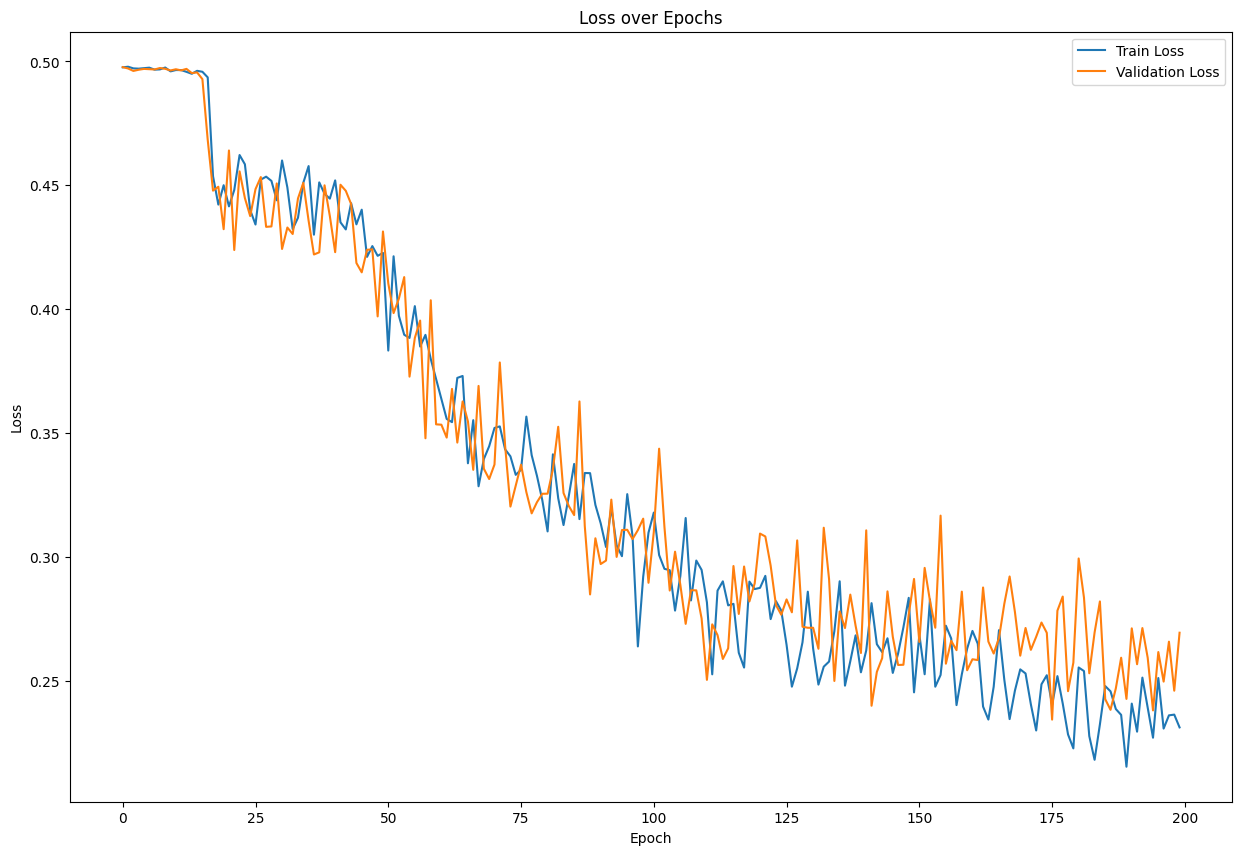

In [36]:
# Assuming epoch_list, losses_train, and losses_val are already defined
plt.figure(figsize=(15, 10))

# Plot training and validation loss
plt.plot(epoch_list, losses_train, label='Train Loss')
plt.plot(epoch_list, losses_val, label='Validation Loss')

# # Add vertical lines at specific epochs, e.g., at epochs 5, 10, and 20
# important_epochs = [0,1,2,3,5,17,20,38,39, 49, 53, 66,83, 85]
# for epoch in important_epochs:
#     plt.axvline(x=epoch, color='green', linestyle='--', linewidth=0.5, alpha=0.7, label='Improvement detected' if epoch == important_epochs[0] else "")

plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [37]:
# Define your models_save_path
models_save_path = "workspace/models/learning_rates/"

# Create the directory if it does not exist
if not os.path.exists(models_save_path):
    os.makedirs(models_save_path)


# Create a DataFrame for training and validation losses
losses_df = pd.DataFrame({
    'epoch': epoch_list,
    'learning_rate': learning_rates_epochs,
    'train_loss': losses_train,
    'val_loss': losses_val
})

# Save the losses to a CSV file
losses_csv_path = os.path.join(models_save_path, 'onecycle_LR_1.csv')
losses_df.to_csv(losses_csv_path, index=False)

# print(f"Learning rates saved to {learning_rate_csv_path}")
print(f"Training and validation losses saved to {losses_csv_path}")


Training and validation losses saved to workspace/models/learning_rates/onecycle_LR_1.csv


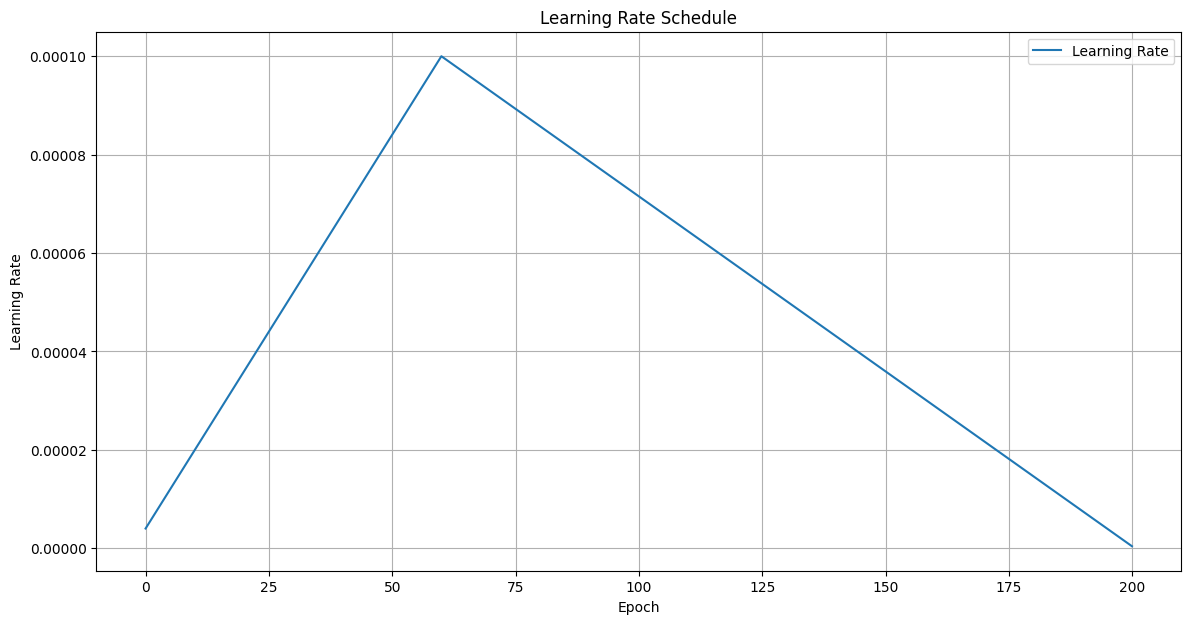

In [57]:
epochs = len(learning_rates_batches) // 25

# Create x-axis values, each epoch will have 25 points
x = [i / 25 for i in range(len(learning_rates_batches))]

plt.figure(figsize=(14, 7))
plt.plot(x, learning_rates_batches, label='Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')
plt.legend()
plt.grid(True)
plt.show()

In [30]:
# Best model so far
model_1 = UNet(in_channels=1, out_channels=1) 

# Load the state dictionary from the path where you saved it
model_path = 'workspace/models/27_06_2024_BCE_dice_50_50/model_2024-06-27_22-19-01.pth'  # Adjust the path and filename
model_1.load_state_dict(torch.load(model_path))
model_1.to(device)

UNet(
  (down1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (down2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (down3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (down4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (down5): Sequential(
    (0): Conv2d(512, 1024, ke

In [31]:
from sklearn.metrics import roc_curve, auc

model_1.eval()
total_val_loss = 0
all_predictions = []
all_targets = []

with torch.no_grad():
    for batch_idx, (img, mask, weights, _, _, _) in enumerate(dataloader_test):

        print("batch_idx: ", batch_idx)
                
        img = img.to(device, dtype=torch.float)


        mask = mask.to(device, dtype=torch.float)
        output = model_1(img)
        print(output.shape)
        predicted_probs = torch.sigmoid(output).cpu().numpy()
        print(predicted_probs.shape)
        all_predictions.append(predicted_probs)
        all_targets.append(mask.cpu().numpy())
        
        


batch_idx:  0
torch.Size([30, 1, 256, 256])
(30, 1, 256, 256)
batch_idx:  1
torch.Size([30, 1, 256, 256])
(30, 1, 256, 256)
batch_idx:  2
torch.Size([30, 1, 256, 256])
(30, 1, 256, 256)
batch_idx:  3
torch.Size([30, 1, 256, 256])
(30, 1, 256, 256)
batch_idx:  4
torch.Size([30, 1, 256, 256])
(30, 1, 256, 256)
batch_idx:  5
torch.Size([30, 1, 256, 256])
(30, 1, 256, 256)
batch_idx:  6
torch.Size([8, 1, 256, 256])
(8, 1, 256, 256)


In [32]:
from sklearn.metrics import roc_curve, auc

In [33]:
all_predictions = np.concatenate(all_predictions, axis=0)
all_targets = np.concatenate(all_targets, axis=0)

In [34]:
all_predictions.shape

(188, 1, 256, 256)

In [147]:
np.min(all_predictions), np.max(all_predictions)

(6.403496e-11, 1.0)

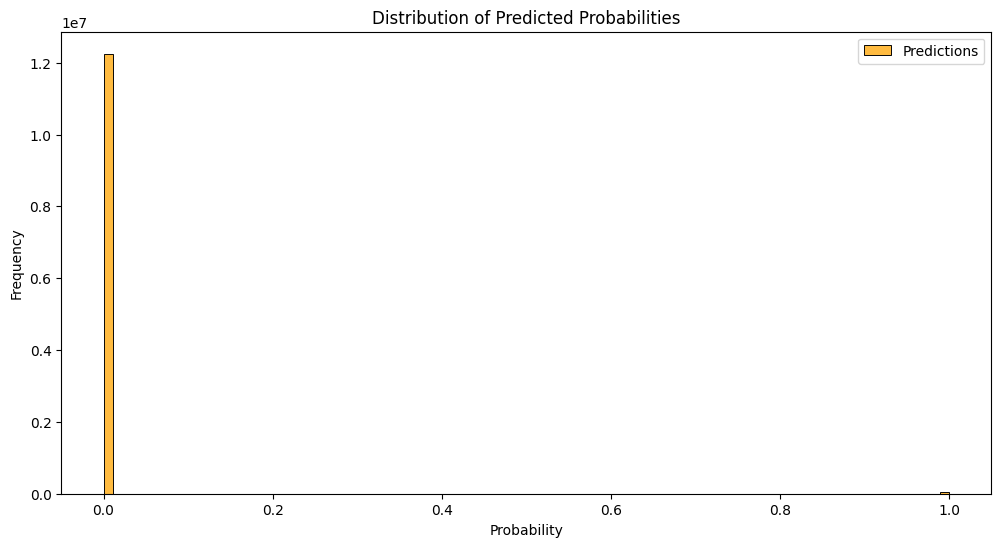

In [148]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

all_predictions_flattened = all_predictions.flatten()

# Plotting the distribution of predictions
plt.figure(figsize=(12, 6))

sns.histplot(all_predictions_flattened, kde=False, color='orange', label='Predictions', bins=90)

plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Probabilities')
plt.legend()
plt.show()


In [36]:
labels = np.squeeze(np.array(all_targets, dtype=bool)).flatten()
pred = np.squeeze(all_predictions).flatten()

In [37]:
import sklearn.metrics

def get_EER(
    fpr,
    tpr,
    thrs):

    """

        Compute equal error rates and thresholds

    Args:

        fpr: false positive rate

        tpr: true positive rates

        thrs:

    Returns:

        equal error rates and thresholds

    """

    # Equal Error Rate (EER)

    fnr = 1 - tpr
    eer_threshold = thrs[np.nanargmin(np.absolute((fnr - fpr)))]
    EER = fpr[np.nanargmin(np.absolute((fnr - fpr)))]

    return EER, eer_threshold   



def calculate_and_plot_ROC(labels, pred, results_path, title_complement=""):
    
    # ### AUC
    #(does not depend on threshold)
    auc_metric = sklearn.metrics.roc_auc_score(y_true=labels, 
                                  y_score=pred)

    #ROC
    fpr, tpr, thrs = sklearn.metrics.roc_curve(labels, pred)
    EER, eer_threshold = get_EER(fpr, tpr, thrs)
    
    fig,ax = plt.subplots(figsize=(7,7))
    lw = 2
    ax.plot(
        fpr, tpr, color="darkorange", lw=lw, label="ROC curve (area = %0.4f)" % auc_metric,
    )
    ax.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("ROC{}\nEER: {:0.2f} eer_thr: {:0.4f}".format(title_complement, EER, eer_threshold))
    ax.legend(loc="lower right")
#     fig.savefig(os.path.join(results_path, "ROC{}.png".format(title_complement)), dpi=100)

    plt.show()
    
    return auc_metric, EER, eer_threshold

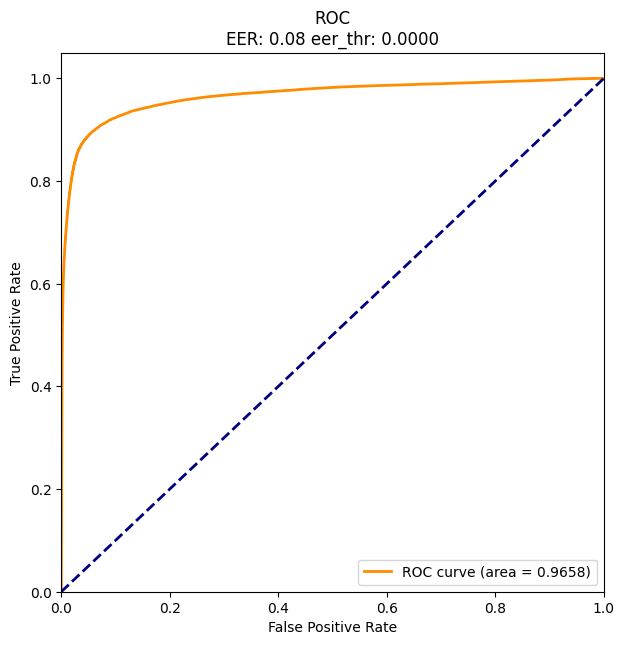

In [38]:
auc_metric, EER, eer_threshold = calculate_and_plot_ROC(labels, pred, "")

In [111]:
eer_threshold

0.0035338036

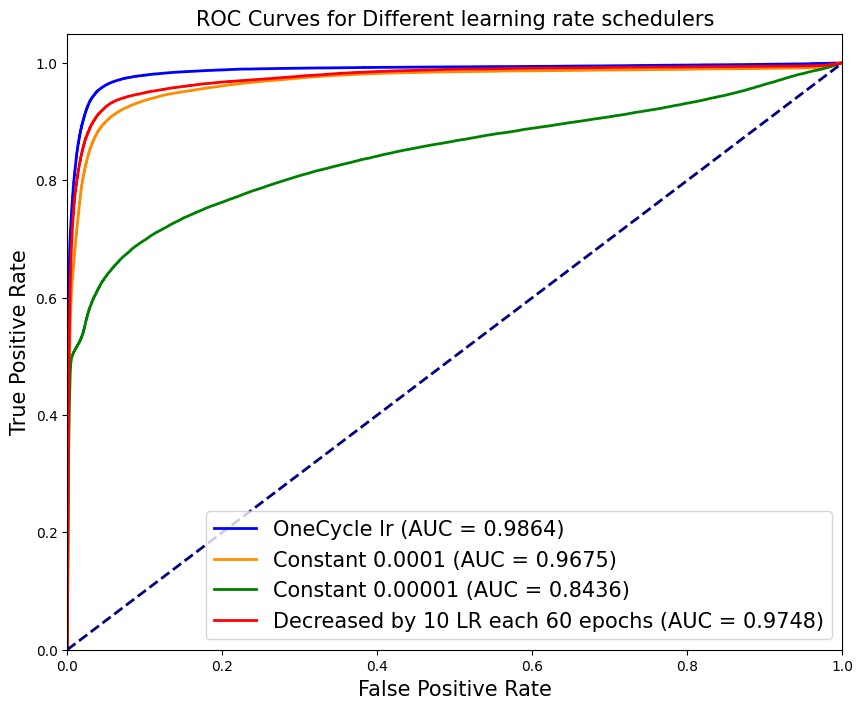

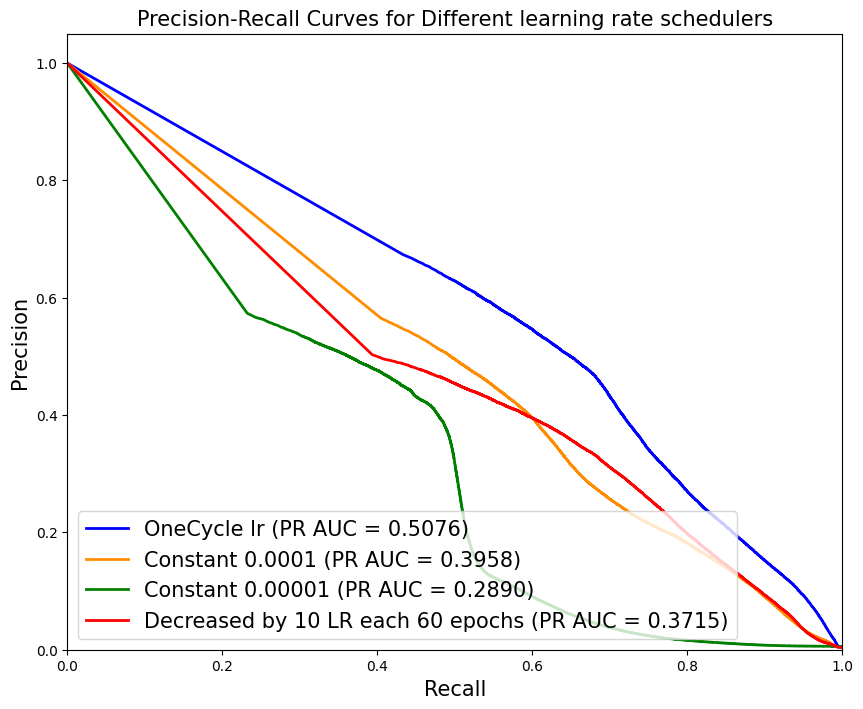

In [30]:
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, average_precision_score, jaccard_score, auc
import torch
import numpy as np
import matplotlib.pyplot as plt

# Function to calculate and plot ROC for multiple models
def calculate_and_plot_ROC(labels_list, preds_list, model_names, colors):
    plt.figure(figsize=(10, 8))

    for i, (labels, pred) in enumerate(zip(labels_list, preds_list)):
        fpr, tpr, _ = roc_curve(labels, pred)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color=colors[i], lw=2, label=f'{model_names[i]} (AUC = {roc_auc:.4f})')
    
    # Plot configuration
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate", fontsize=15)
    plt.ylabel("True Positive Rate", fontsize=15)
    plt.title("ROC Curves for Different learning rate schedulers", fontsize=15)
    plt.legend(loc="lower right", fontsize=15)
    plt.show()


# Function to calculate and plot Precision-Recall curve for multiple models
def calculate_and_plot_PR(labels_list, preds_list, model_names, colors):
    plt.figure(figsize=(10, 8))
    
    for i, (labels, pred) in enumerate(zip(labels_list, preds_list)):
        precision, recall, _ = precision_recall_curve(labels, pred)
        pr_auc = average_precision_score(labels, pred)
        plt.plot(recall, precision, color=colors[i], lw=2, label=f'{model_names[i]} (PR AUC = {pr_auc:.4f})')
    
    # Plot configuration
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("Recall", fontsize=15)
    plt.ylabel("Precision", fontsize=15)
    plt.title("Precision-Recall Curves for Different learning rate schedulers", fontsize=15)
    plt.legend(loc="lower left", fontsize=15)
    plt.show()


# Paths to the model files
model_paths = [
    # 'workspace/models/27_06_2024_BCE_dice_50_50/model_2024-06-27_22-19-01.pth',
    # 'workspace/models/11_06_2024_only_BCE_with_weight/model_2024-06-11_23-12-00.pth',
    # 'workspace/models/11_06_2024_only_BCE_without_weight/model_2024-06-11_17-53-05.pth',
    # 'workspace/models/18_06_2024_only_Dice/model_2024-06-18_19-59-41.pth'
    'workspace/models/27_06_2024_BCE_dice_50_50/model_2024-06-27_22-19-01.pth',
    'workspace/models/13_07_2024_BCE_dice_50_50_learning_rate_constant_0.0001/model_2024-07-13_14-09-19.pth',
    'workspace/models/14_07_2024_BCE_dice_50_50_learning_rate_constant_0.00001/model_2024-07-14_15-41-03.pth',
    'workspace/models/17_07_2024_BCE_dice_50_50_learning_rate_decrease_each_60/model_2024-07-17_17-01-13.pth'
    
]

model_names = [
    # 'BCE + Dice',
    # 'BCE with weights',
    # 'BCE without weights',
    # 'Dice'
    'OneCycle lr',
    'Constant 0.0001',
    'Constant 0.00001',
    'Decreased by 10 LR each 60 epochs'
    
]

colors = ['blue','darkorange', 'green', 'red']

labels_list = []
preds_list = []

for model_path in model_paths:
    model = UNet(in_channels=1, out_channels=1)  
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()

    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for batch_idx, (img, mask, weights, _, _, _) in enumerate(dataloader_test):
            img = img.to(device, dtype=torch.float)
            mask = mask.to(device, dtype=torch.float)
            output = model(img)
            predicted_probs = torch.sigmoid(output).cpu().numpy()
            all_predictions.append(predicted_probs)
            all_targets.append(mask.cpu().numpy())
    
    all_predictions = np.concatenate(all_predictions, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)

    labels = np.squeeze(np.array(all_targets, dtype=bool)).flatten()
    pred = np.squeeze(all_predictions).flatten()

    labels_list.append(labels)
    preds_list.append(pred)

# Plot ROC curves for all models
calculate_and_plot_ROC(labels_list, preds_list, model_names, colors)

# Plot PR curves for all models
calculate_and_plot_PR(labels_list, preds_list, model_names, colors)



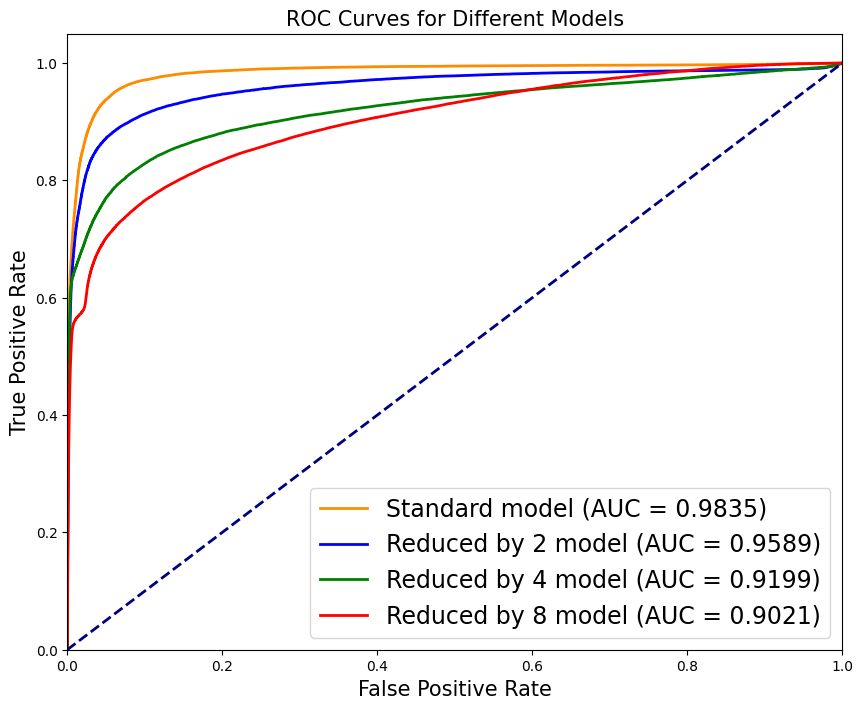

In [28]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, average_precision_score, jaccard_score


class UNet(nn.Module):
    def __init__(self, in_channels, out_channels, filters):
        super(UNet, self).__init__()
        
        def double_conv(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            )
        
        self.down1 = double_conv(in_channels, filters[0])
        self.down2 = double_conv(filters[0], filters[1])
        self.down3 = double_conv(filters[1], filters[2])
        self.down4 = double_conv(filters[2], filters[3])
        self.down5 = double_conv(filters[3], filters[4])
        
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.up4 = nn.ConvTranspose2d(filters[4], filters[3], kernel_size=2, stride=2)
        self.up_conv4 = double_conv(filters[4], filters[3])
        self.up3 = nn.ConvTranspose2d(filters[3], filters[2], kernel_size=2, stride=2)
        self.up_conv3 = double_conv(filters[3], filters[2])
        self.up2 = nn.ConvTranspose2d(filters[2], filters[1], kernel_size=2, stride=2)
        self.up_conv2 = double_conv(filters[2], filters[1])
        self.up1 = nn.ConvTranspose2d(filters[1], filters[0], kernel_size=2, stride=2)
        
        self.up_conv1 = nn.Sequential(
            nn.Conv2d(filters[1], filters[0], kernel_size=3, padding=1),
            nn.Conv2d(filters[0], filters[0], kernel_size=3, padding=1)
        )
        self.final_conv = nn.Conv2d(filters[0], out_channels, kernel_size=1)
    
    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.maxpool(d1)
        d2 = self.down2(d2)
        d3 = self.maxpool(d2)
        d3 = self.down3(d3)
        d4 = self.maxpool(d3)
        d4 = self.down4(d4)
        d5 = self.maxpool(d4)
        d5 = self.down5(d5)
        
        u4 = self.up4(d5)
        u4 = torch.cat((d4, u4), dim=1)
        u4 = self.up_conv4(u4)
        u3 = self.up3(u4)
        u3 = torch.cat((d3, u3), dim=1)
        u3 = self.up_conv3(u3)
        u2 = self.up2(u3)
        u2 = torch.cat((d2, u2), dim=1)
        u2 = self.up_conv2(u2)
        u1 = self.up1(u2)
        u1 = torch.cat((d1, u1), dim=1)
        u1 = self.up_conv1(u1)
        
        out = self.final_conv(u1)
        return out

# Paths to the model files
model_paths = [
    'workspace/models/27_06_2024_BCE_dice_50_50/model_2024-06-27_22-19-01.pth',
    'workspace/models/08_07_2024_BCE_dice_50_50_reduced_by_2/model_2024-07-08_20-24-41.pth',
    'workspace/models/04_07_2024_BCE_dice_50_50_reduced_by_4/model_2024-07-04_23-11-17.pth',
    'workspace/models/07_07_2024_BCE_dice_50_50_reduced_by_8/model_2024-07-07_17-43-07.pth'
]

# Filters for each model
filter_settings = [
    [64, 128, 256, 512, 1024],
    [32, 64, 128, 256, 512],  # Reduced by 2
    [16, 32, 64, 128, 256],   # Reduced by 4
    [8, 16, 32, 64, 128]      # Reduced by 8
]

# Colors for the ROC curves
colors = ['darkorange', 'blue', 'green', 'red']

# Function to calculate and plot ROC
def calculate_and_plot_ROC(labels, pred, label_name, color):
    fpr, tpr, _ = roc_curve(labels, pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, lw=2, label=f'{label_name} (AUC = {roc_auc:.4f})')
    return roc_auc


def calculate_and_plot_PR(labels, pred, label_name, color):
    precision, recall, _ = precision_recall_curve(labels, pred)
    pr_auc = average_precision_score(labels, pred)
    plt.plot(recall, precision, color=color, lw=2, label=f'{label_name} (PR AUC = {pr_auc:.4f})')



# Load and evaluate each model
plt.figure(figsize=(10, 8))

for i, (model_path, filters) in enumerate(zip(model_paths, filter_settings)):
    model = UNet(in_channels=1, out_channels=1, filters=filters)  # Adjust channels as necessary
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()

    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for batch_idx, (img, mask, weights, _, _, _) in enumerate(dataloader_test):
            img = img.to(device, dtype=torch.float)
            mask = mask.to(device, dtype=torch.float)
            output = model(img)
            predicted_probs = torch.sigmoid(output).cpu().numpy()
            all_predictions.append(predicted_probs)
            all_targets.append(mask.cpu().numpy())
    
    all_predictions = np.concatenate(all_predictions, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)

    labels = np.squeeze(np.array(all_targets, dtype=bool)).flatten()
    pred = np.squeeze(all_predictions).flatten()

    if i == 0:
        calculate_and_plot_ROC(labels, pred, f'Standard model', colors[i])
        # calculate_and_plot_PR(labels, pred, f'Standard model', colors[i])
    elif i == 1:
        calculate_and_plot_ROC(labels, pred, f'Reduced by 2 model', colors[i])
        # calculate_and_plot_PR(labels, pred, f'Reduced by 2 model', colors[i])
    elif i == 2:
        calculate_and_plot_ROC(labels, pred, f'Reduced by 4 model', colors[i])
        # calculate_and_plot_PR(labels, pred, f'Reduced by 4 model', colors[i])
    elif i == 3:
        calculate_and_plot_ROC(labels, pred, f'Reduced by 8 model', colors[i])
        # calculate_and_plot_PR(labels, pred, f'Reduced by 8 model', colors[i])
        

# Plot configuration
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate", fontsize=15)
plt.ylabel("True Positive Rate", fontsize=15)
plt.title("ROC Curves for Different Models", fontsize=15)
# plt.xlabel("Recall", fontsize=15)
# plt.ylabel("Precision",fontsize=15 )
# plt.title("Precision-Recall Curves for Different Models", fontsize=15)
plt.legend(loc="lower right", fontsize=17)
plt.show()


In [2]:
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels, filters):
        super(UNet, self).__init__()
        
        def double_conv(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            )
        
        self.down1 = double_conv(in_channels, filters[0])
        self.down2 = double_conv(filters[0], filters[1])
        self.down3 = double_conv(filters[1], filters[2])
        self.down4 = double_conv(filters[2], filters[3])
        self.down5 = double_conv(filters[3], filters[4])
        
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.up4 = nn.ConvTranspose2d(filters[4], filters[3], kernel_size=2, stride=2)
        self.up_conv4 = double_conv(filters[4], filters[3])
        self.up3 = nn.ConvTranspose2d(filters[3], filters[2], kernel_size=2, stride=2)
        self.up_conv3 = double_conv(filters[3], filters[2])
        self.up2 = nn.ConvTranspose2d(filters[2], filters[1], kernel_size=2, stride=2)
        self.up_conv2 = double_conv(filters[2], filters[1])
        self.up1 = nn.ConvTranspose2d(filters[1], filters[0], kernel_size=2, stride=2)
        
        self.up_conv1 = nn.Sequential(
            nn.Conv2d(filters[1], filters[0], kernel_size=3, padding=1),
            nn.Conv2d(filters[0], filters[0], kernel_size=3, padding=1)
        )
        self.final_conv = nn.Conv2d(filters[0], out_channels, kernel_size=1)
    
    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.maxpool(d1)
        d2 = self.down2(d2)
        d3 = self.maxpool(d2)
        d3 = self.down3(d3)
        d4 = self.maxpool(d3)
        d4 = self.down4(d4)
        d5 = self.maxpool(d4)
        d5 = self.down5(d5)
        
        u4 = self.up4(d5)
        u4 = torch.cat((d4, u4), dim=1)
        u4 = self.up_conv4(u4)
        u3 = self.up3(u4)
        u3 = torch.cat((d3, u3), dim=1)
        u3 = self.up_conv3(u3)
        u2 = self.up2(u3)
        u2 = torch.cat((d2, u2), dim=1)
        u2 = self.up_conv2(u2)
        u1 = self.up1(u2)
        u1 = torch.cat((d1, u1), dim=1)
        u1 = self.up_conv1(u1)
        
        out = self.final_conv(u1)
        return out

# Paths to the model files
model_paths = [
    'workspace/models/27_06_2024_BCE_dice_50_50/model_2024-06-27_22-19-01.pth',
    'workspace/models/08_07_2024_BCE_dice_50_50_reduced_by_2/model_2024-07-08_20-24-41.pth',
    'workspace/models/04_07_2024_BCE_dice_50_50_reduced_by_4/model_2024-07-04_23-11-17.pth',
    'workspace/models/07_07_2024_BCE_dice_50_50_reduced_by_8/model_2024-07-07_17-43-07.pth'
]

# Filters for each model
filter_settings = [
    [64, 128, 256, 512, 1024],
    [32, 64, 128, 256, 512],  # Reduced by 2
    [16, 32, 64, 128, 256],   # Reduced by 4
    [8, 16, 32, 64, 128]      # Reduced by 8
]

# Colors for the ROC curves
colors = ['darkorange', 'blue', 'green', 'red']

# Load each model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
models = []

for model_path, filters in zip(model_paths, filter_settings):
    model = UNet(in_channels=1, out_channels=1, filters=filters)
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()
    models.append(model)

# Test each model on the same data and plot the results
iter = 0
with torch.no_grad():
    for batch_idx, (img, mask, mask_weight, white_pixs_array, orig_image, borders) in enumerate(dataloader_test):
        if iter == 2:  # Limit to 2 iterations for testing
            break
        
        img = img.to(device, dtype=torch.float)
        mask = mask.to(device, dtype=torch.float)

        # Initialize a list to hold predictions from each model
        predicted_probs = []

        # Get predictions from each model
        for model in models:
            output = model(img)
            predicted_probs.append(torch.sigmoid(output).cpu().numpy())

        # Plot results
        for i in range(img.shape[0]):
            im = img[i].cpu().numpy().transpose(1, 2, 0)
            
            if torch.is_tensor(orig_image[i]):
                orig_image_numpy = orig_image[i].numpy()
            else:
                orig_image_numpy = orig_image[i]

            ma = mask[i].cpu().numpy().transpose(1, 2, 0)

            # Create a plot for each model's prediction
            fig, axs = plt.subplots(1, len(models) + 2, figsize=(20, 12), dpi=100)
            axs[0].imshow(im, cmap='gray')
            axs[0].set_title('Original Crop', fontsize=15)
            axs[0].axis('off')  

            axs[1].imshow(ma, cmap='gray', vmin=0, vmax=1) 
            axs[1].set_title('Original Mask', fontsize=15)
            axs[1].axis('off')

            # Iterate through each model's prediction
            for j, predicted_prob in enumerate(predicted_probs):
                predicted_mask = predicted_prob[i].transpose(1, 2, 0)
                axs[j+2].imshow(predicted_mask, cmap='gray')

                # Set titles based on the model architecture
                if j == 0:
                    axs[j+2].set_title('Standard Model', fontsize=15)
                elif j == 1:
                    axs[j+2].set_title('Reduced by 2 Model', fontsize=15)
                elif j == 2:
                    axs[j+2].set_title('Reduced by 4 Model', fontsize=15)
                elif j == 3:
                    axs[j+2].set_title('Reduced by 8 Model', fontsize=15)

                axs[j+2].axis('off')

            plt.show()

        iter += 1

In [3]:
# Without threshold, non binarized images 
model_1.eval()
iter = 0
with torch.no_grad():
    for batch_idx, (img, mask, mask_weight, white_pixs_array, orig_image, borders) in enumerate(dataloader_test):

        if iter == 2:
            break
        print("Iter: ", iter)
        img_plot = img.clone()
        
        img = img.to(device, dtype=torch.float)
        mask = mask.to(device, dtype=torch.float)
        output = model_1(img)

        for i in range(img.shape[0]):
            im = img[i].cpu().numpy().transpose(1, 2, 0)
            predicted_prob = torch.sigmoid(output[i]).cpu().numpy().squeeze()
            # print("Threshold: ", threshold)
            print("Max value: ", np.max(predicted_prob))
            print("min value: ", np.min(predicted_prob))
            print("predicted_prob.shape: ", predicted_prob.shape)
            
            if torch.is_tensor(orig_image[i]):
                orig_image_numpy = orig_image[i].numpy()
            else:
                orig_image_numpy = orig_image[i]

            y = int(white_pixs_array[i][1])
            x = int(white_pixs_array[i][2])
            color = [255, 0, 0] 

            x0, x1, y0, y1 = borders[i]
            orig_image_modified = draw_red_square(orig_image_numpy.transpose(1, 2, 0).astype(np.uint8), y, x, size=10)
            orig_image_with_blue_rectangle = draw_blue_rectangle(orig_image_modified, x0, x1, y0, y1, border_thickness=3)

            ma = mask[i].cpu().numpy().transpose(1, 2, 0)

            print("ma.shape: ", ma.shape)
            print("Amount of 1 of mask: ", np.count_nonzero(ma == 1.0))
            print("Amount of 0 of mask: ", np.count_nonzero(ma == 0.0))
            print("--------------------------")

            image_rgb = im
            print(f"Picture number {i}")

            plt.figure(figsize=(8, 6))
            plt.imshow(orig_image_with_blue_rectangle, cmap='gray') 
            plt.title('Original image', fontsize=15)
            plt.axis('off') 

            plt.show()
            
            plt.figure(figsize=(15, 12), dpi=100)

            plt.subplot(1, 3, 1)  
            plt.imshow(im, cmap='gray')
            plt.title('Crop Original', fontsize=15)
            plt.axis('off')  

            plt.subplot(1, 3, 2) 
            plt.imshow(ma, cmap='gray', vmin=0, vmax=1) 
            plt.title('Mask Original', fontsize=15)
            plt.axis('off')
            
            plt.subplot(1, 3, 3)  
            plt.imshow(predicted_prob, cmap='gray') 
            plt.title('Mask Predicted', fontsize=15)
            plt.axis('off') 

            plt.show()

            # plt.figure(figsize=(8, 6))
            # plt.imshow(orig_image_with_blue_rectangle, cmap='gray') 
            # plt.title('Orig_image')
            # plt.axis('off') 

            # plt.show()
            
            plt.hist(predicted_prob.ravel(), bins=50, color='blue', alpha=0.7)
            plt.title('Histogram of Predicted Probabilities')
            plt.show()

            plt.imshow(predicted_prob.squeeze(), cmap='viridis')
            plt.colorbar() 
            plt.title('Predicted Probabilities with Adjusted Colormap')
            plt.show()
            print("-------------")
        iter += 1


In [4]:
# Initialize device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define model paths
model_paths = [
            'workspace/models/27_06_2024_BCE_dice_50_50/model_2024-06-27_22-19-01.pth',
            'workspace/models/18_06_2024_only_Dice/model_2024-06-18_19-59-41.pth',
            'workspace/models/11_06_2024_only_BCE_without_weight/model_2024-06-11_17-53-05.pth',
            'workspace/models/11_06_2024_only_BCE_with_weight/model_2024-06-11_23-12-00.pth'
            # 'workspace/models/13_07_2024_BCE_dice_50_50_learning_rate_constant_0.0001/model_2024-07-13_14-09-19.pth',
            # 'workspace/models/14_07_2024_BCE_dice_50_50_learning_rate_constant_0.00001/model_2024-07-14_15-41-03.pth',
            # 'workspace/models/17_07_2024_BCE_dice_50_50_learning_rate_decrease_each_60/model_2024-07-17_17-01-13.pth',
            # 'workspace/models/27_06_2024_BCE_dice_50_50/model_2024-06-27_22-19-01.pth'
              
              ]

# Load each model
models = []
for path in model_paths:
    print(path)
    model = UNet(in_channels=1, out_channels=1)  # Adjust in/out channels if needed
    model.load_state_dict(torch.load(path))
    model.to(device)
    model.eval()
    models.append(model)

# Test each model on the same data and plot the results
iter = 0
with torch.no_grad():
    for batch_idx, (img, mask, mask_weight, white_pixs_array, orig_image, borders) in enumerate(dataloader_test):
        if iter == 2:  # Limit to 2 iterations for testing
            break
        print("Iter: ", iter)

        img = img.to(device, dtype=torch.float)
        mask = mask.to(device, dtype=torch.float)

        # Initialize a list to hold predictions from each model
        predicted_probs = []

        # Get predictions from each model
        for model in models:
            output = model(img)
            predicted_probs.append(torch.sigmoid(output).cpu().numpy())

        # Plot results
        for i in range(img.shape[0]):
            im = img[i].cpu().numpy().transpose(1, 2, 0)
            
            if torch.is_tensor(orig_image[i]):
                orig_image_numpy = orig_image[i].numpy()
            else:
                orig_image_numpy = orig_image[i]

            y = int(white_pixs_array[i][1])
            x = int(white_pixs_array[i][2])

            x0, x1, y0, y1 = borders[i]
            orig_image_modified = draw_red_square(orig_image_numpy.transpose(1, 2, 0).astype(np.uint8), y, x, size=10)
            orig_image_with_blue_rectangle = draw_blue_rectangle(orig_image_modified, x0, x1, y0, y1, border_thickness=3)

            ma = mask[i].cpu().numpy().transpose(1, 2, 0)

            print("ma.shape: ", ma.shape)
            print("Amount of 1 of mask: ", np.count_nonzero(ma == 1.0))
            print("Amount of 0 of mask: ", np.count_nonzero(ma == 0.0))
            print("--------------------------")

            image_rgb = im
            print(f"Picture number {i}")

            # Create a plot for each model's prediction
            fig, axs = plt.subplots(1, len(models) + 2, figsize=(20, 12), dpi=100)
            axs[0].imshow(im, cmap='gray')
            axs[0].set_title('Original Crop', fontsize=15)
            axs[0].axis('off')  

            axs[1].imshow(ma, cmap='gray', vmin=0, vmax=1) 
            axs[1].set_title('Original Mask', fontsize=15)
            axs[1].axis('off')

            # Iterate through each model's prediction
            for j, predicted_prob in enumerate(predicted_probs):
                # Plot the predicted mask for the current model
                predicted_mask = predicted_prob[i].transpose(1, 2, 0)  # Ensure the shape is correct for imshow
                axs[j+2].imshow(predicted_mask, cmap='gray')
                if j == 0:
                    axs[j+2].set_title(f'BCE + Dice 50-50', fontsize=15)
                    # axs[j+2].set_title(f'Constant 0.0001 LR', fontsize=15)
                elif j == 1:
                    axs[j+2].set_title(f'Dice', fontsize=15)
                    # axs[j+2].set_title(f'Constant 0.00001 LR', fontsize=15)
                elif j == 2:
                    axs[j+2].set_title(f'BCE without weights', fontsize=15)
                    # axs[j+2].set_title(f'Step LR', fontsize=15)
                elif j == 3:
                    axs[j+2].set_title(f'BCE with weights', fontsize=15)
                    # axs[j+2].set_title(f'One Cycle LR', fontsize=15)
                axs[j+2].axis('off')

            plt.show()

            plt.figure(figsize=(8, 6))
            plt.imshow(orig_image_with_blue_rectangle, cmap='gray') 
            plt.title('Original Image with Annotations', fontsize=15)
            plt.axis('off') 
            plt.show()

            print("-------------")
        iter += 1

In [5]:
# Define separate thresholds for each model
thresholds = [0.8, 0.8, 0.05, 0.95]  # Adjust these threshold values as needed for each model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define model paths
model_paths = ['workspace/models/27_06_2024_BCE_dice_50_50/model_2024-06-27_22-19-01.pth',
               'workspace/models/18_06_2024_only_Dice/model_2024-06-18_19-59-41.pth',
               'workspace/models/11_06_2024_only_BCE_without_weight/model_2024-06-11_17-53-05.pth',
               'workspace/models/11_06_2024_only_BCE_with_weight/model_2024-06-11_23-12-00.pth']

# Load each model
models = []
for path in model_paths:
    print(path)
    model = UNet(in_channels=1, out_channels=1)  # Adjust in/out channels if needed
    model.load_state_dict(torch.load(path))
    model.to(device)
    model.eval()
    models.append(model)

# Test each model on the same data and plot the results
iter = 0
with torch.no_grad():
    for batch_idx, (img, mask, mask_weight, white_pixs_array, orig_image, borders) in enumerate(dataloader_test):
        if iter == 2:  # Limit to 2 iterations for testing
            break
        print("Iter: ", iter)

        img = img.to(device, dtype=torch.float)
        mask = mask.to(device, dtype=torch.float)

        # Initialize a list to hold predictions from each model
        predicted_probs = []

        # Get predictions from each model
        for model in models:
            output = model(img)
            predicted_probs.append(torch.sigmoid(output).cpu().numpy())

        # Plot results
        for i in range(img.shape[0]):
            im = img[i].cpu().numpy().transpose(1, 2, 0)
            
            if torch.is_tensor(orig_image[i]):
                orig_image_numpy = orig_image[i].numpy()
            else:
                orig_image_numpy = orig_image[i]

            y = int(white_pixs_array[i][1])
            x = int(white_pixs_array[i][2])

            x0, x1, y0, y1 = borders[i]
            orig_image_modified = draw_red_square(orig_image_numpy.transpose(1, 2, 0).astype(np.uint8), y, x, size=10)
            orig_image_with_blue_rectangle = draw_blue_rectangle(orig_image_modified, x0, x1, y0, y1, border_thickness=3)

            ma = mask[i].cpu().numpy().transpose(1, 2, 0)

            print("ma.shape: ", ma.shape)
            print("Amount of 1 of mask: ", np.count_nonzero(ma == 1.0))
            print("Amount of 0 of mask: ", np.count_nonzero(ma == 0.0))
            print("--------------------------")

            image_rgb = im
            print(f"Picture number {i}")

            # Create a plot for each model's prediction
            fig, axs = plt.subplots(1, len(models) + 2, figsize=(20, 12), dpi=100)
            axs[0].imshow(im, cmap='gray')
            axs[0].set_title('Original Crop', fontsize=15)
            axs[0].axis('off')  

            axs[1].imshow(ma, cmap='gray', vmin=0, vmax=1) 
            axs[1].set_title('Original Mask', fontsize=15)
            axs[1].axis('off')

            # Iterate through each model's prediction and apply the respective threshold
            for j, (predicted_prob, threshold) in enumerate(zip(predicted_probs, thresholds)):
                # Apply the respective threshold for each model
                predicted_mask = (predicted_prob[i].transpose(1, 2, 0) >= threshold).astype(np.uint8)
                
                # Plot the predicted mask for the current model
                axs[j+2].imshow(predicted_mask, cmap='gray', vmin=0, vmax=1)
                if j == 0:
                    axs[j+2].set_title(f'BCE + Dice 50-50', fontsize=15)
                elif j == 1:
                    axs[j+2].set_title(f'Dice', fontsize=15)
                elif j == 2:
                    axs[j+2].set_title(f'BCE without weights', fontsize=15)
                elif j == 3:
                    axs[j+2].set_title(f'BCE with weights', fontsize=15)
                axs[j+2].axis('off')

            plt.show()

            plt.figure(figsize=(8, 6))
            plt.imshow(orig_image_with_blue_rectangle, cmap='gray') 
            plt.title('Original Image with Annotations', fontsize=15)
            plt.axis('off') 
            plt.show()

            print("-------------")
        iter += 1


In [6]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import torch
import matplotlib.pyplot as plt

# Ensure that all necessary functions and imports (e.g., draw_red_square, draw_blue_rectangle, dataloader_test) are already defined

# Initialize device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define model paths
model_paths = [
    'workspace/models/27_06_2024_BCE_dice_50_50/model_2024-06-27_22-19-01.pth',
    'workspace/models/18_06_2024_only_Dice/model_2024-06-18_19-59-41.pth',
    'workspace/models/11_06_2024_only_BCE_without_weight/model_2024-06-11_17-53-05.pth',
    'workspace/models/11_06_2024_only_BCE_with_weight/model_2024-06-11_23-12-00.pth'
]

model_names = ['BCE + Dice', 'Dice', 'BCE without weights', 'BCE with weights']

# Load each model
models = []
for path in model_paths:
    print(path)
    model = UNet(in_channels=1, out_channels=1)  # Adjust in/out channels if needed
    model.load_state_dict(torch.load(path))
    model.to(device)
    model.eval()
    models.append(model)

# Initialize lists to store labels and predictions for ROC calculations
labels_list = []
preds_list = []

# Collect predictions for calculating thresholds
for model in models:
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for batch_idx, (img, mask, _, _, _, _) in enumerate(dataloader_test):
            img = img.to(device, dtype=torch.float)
            mask = mask.to(device, dtype=torch.float)
            output = model(img)
            predicted_probs = torch.sigmoid(output).cpu().numpy()
            all_predictions.append(predicted_probs)
            all_targets.append(mask.cpu().numpy())
    
    all_predictions = np.concatenate(all_predictions, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)

    labels = np.squeeze(np.array(all_targets, dtype=bool)).flatten()
    pred = np.squeeze(all_predictions).flatten()

    labels_list.append(labels)
    preds_list.append(pred)

# Calculate thresholds for TPR of 0.85
objective_TPR = 0.9
thresholds_for_tpr_adjusted = {}

# Calculate the adjusted thresholds for each model to achieve the new TPR
for model_name, (labels, preds) in zip(model_names, zip(labels_list, preds_list)):
    fpr, tpr, thresholds = roc_curve(labels, preds)
    
    # Find the index where the TPR is closest to the new objective TPR
    tpr_diff = np.abs(tpr - objective_TPR)
    idx = np.argmin(tpr_diff)
    
    # Store the threshold and corresponding TPR
    calculated_threshold = thresholds[idx]
    calculated_tpr = tpr[idx]
    print(f"Calculated threshold for {model_name}: {calculated_threshold}, TPR: {calculated_tpr}")
    
    # Set a default threshold for models with impractical thresholds
    default_threshold = 0.5  # Commonly used default threshold
    if calculated_threshold <= 0.01 or calculated_threshold >= 0.999:  # Arbitrary cutoff to detect impractical thresholds
        print(f"Threshold for {model_name} is too low ({calculated_threshold}), setting to default {default_threshold}.")
        thresholds_for_tpr_adjusted[model_name] = (default_threshold, objective_TPR)
    else:
        thresholds_for_tpr_adjusted[model_name] = (calculated_threshold, objective_TPR)

print("Adjusted Thresholds for each model:", thresholds_for_tpr_adjusted)

# Test each model on the same data and plot the results
iter = 0
with torch.no_grad():
    for batch_idx, (img, mask, mask_weight, white_pixs_array, orig_image, borders) in enumerate(dataloader_test):
        if iter == 2:  # Limit to 2 iterations for testing
            break
        print("Iter: ", iter)

        img = img.to(device, dtype=torch.float)
        mask = mask.to(device, dtype=torch.float)

        # Initialize a list to hold predictions from each model
        predicted_probs = []

        # Get predictions from each model
        for model in models:
            output = model(img)
            predicted_probs.append(torch.sigmoid(output).cpu().numpy())

        # Plot results
        for i in range(img.shape[0]):
            im = img[i].cpu().numpy().transpose(1, 2, 0)
            
            if torch.is_tensor(orig_image[i]):
                orig_image_numpy = orig_image[i].numpy()
            else:
                orig_image_numpy = orig_image[i]

            y = int(white_pixs_array[i][1])
            x = int(white_pixs_array[i][2])

            x0, x1, y0, y1 = borders[i]
            orig_image_modified = draw_red_square(orig_image_numpy.transpose(1, 2, 0).astype(np.uint8), y, x, size=10)
            orig_image_with_blue_rectangle = draw_blue_rectangle(orig_image_modified, x0, x1, y0, y1, border_thickness=3)

            ma = mask[i].cpu().numpy().transpose(1, 2, 0)

            print("ma.shape: ", ma.shape)
            print("Amount of 1 of mask: ", np.count_nonzero(ma == 1.0))
            print("Amount of 0 of mask: ", np.count_nonzero(ma == 0.0))
            print("--------------------------")

            image_rgb = im
            print(f"Picture number {i}")

            # Create a plot for each model's prediction
            fig, axs = plt.subplots(2, len(models) + 2, figsize=(20, 12), dpi=100)  # Two rows now
            axs[0, 0].imshow(im, cmap='gray')
            axs[0, 0].set_title('Original Crop', fontsize=15)
            axs[0, 0].axis('off')  

            axs[0, 1].imshow(ma, cmap='gray', vmin=0, vmax=1) 
            axs[0, 1].set_title('Original Mask', fontsize=15)
            axs[0, 1].axis('off')

            # Iterate through each model's prediction without threshold
            for j, (predicted_prob, model_name) in enumerate(zip(predicted_probs, model_names)):
                # Plot the predicted mask for the current model without threshold
                predicted_mask = predicted_prob[i].transpose(1, 2, 0)  # Ensure the shape is correct for imshow
                axs[0, j+2].imshow(predicted_mask, cmap='gray')
                axs[0, j+2].set_title(f'{model_name}', fontsize=15)
                axs[0, j+2].axis('off')

                # Apply the respective threshold for each model
                threshold, _ = thresholds_for_tpr_adjusted[model_name]
                predicted_mask_with_threshold = (predicted_prob[i].transpose(1, 2, 0) >= threshold).astype(np.uint8)

                # Plot the predicted mask for the current model with threshold
                axs[1, j+2].imshow(predicted_mask_with_threshold, cmap='gray', vmin=0, vmax=1)
                axs[1, j+2].set_title(f'{model_name}', fontsize=15)
                axs[1, j+2].axis('off')

            axs[1, 0].imshow(im, cmap='gray')
            axs[1, 0].set_title('Original Crop', fontsize=15)
            axs[1, 0].axis('off')  

            axs[1, 1].imshow(ma, cmap='gray', vmin=0, vmax=1) 
            axs[1, 1].set_title('Original Mask', fontsize=15)
            axs[1, 1].axis('off')

            plt.show()

            plt.figure(figsize=(8, 6))
            plt.imshow(orig_image_with_blue_rectangle, cmap='gray') 
            plt.title('Original Image with Annotations', fontsize=15)
            plt.axis('off') 
            plt.show()

            print("-------------")
        iter += 1


## Plots for learning rates

In [24]:
models_save_path = "workspace/models/learning_rates/"

In [25]:
onecycle = os.path.join(models_save_path, 'onecycle_LR.csv')
onecycle_1 = os.path.join(models_save_path, 'onecycle_LR_1.csv')
onecycle_2 = os.path.join(models_save_path, 'onecycle_LR_2.csv')

const_0001 = os.path.join(models_save_path, 'constant_0.0001.csv')
const_0001_1 = os.path.join(models_save_path, 'constant_0.0001_1.csv')
const_0001_2 = os.path.join(models_save_path, 'constant_0.0001_2.csv')


const_00001 = os.path.join(models_save_path, 'constant_0.00001.csv')
const_00001_1 = os.path.join(models_save_path, 'constant_0.00001_1.csv')
const_00001_2 = os.path.join(models_save_path, 'constant_0.00001_2.csv')


decreased_60 = os.path.join(models_save_path, 'decrease_each_60.csv')
decreased_60_1 = os.path.join(models_save_path, 'decrease_each_60_1.csv')
decreased_60_2 = os.path.join(models_save_path, 'decrease_each_60_2.csv')

In [26]:
onecycle_df = pd.read_csv(onecycle)
onecycle_df_1 = pd.read_csv(onecycle_1)
onecycle_df_2 = pd.read_csv(onecycle_2)


const_0001_df = pd.read_csv(const_0001)
const_0001_df_1 = pd.read_csv(const_0001_1)
const_0001_df_2 = pd.read_csv(const_0001_2)


const_00001_df = pd.read_csv(const_00001)
const_00001_df_1 = pd.read_csv(const_00001_1)
const_00001_df_2 = pd.read_csv(const_00001_2)


decreased_60_df = pd.read_csv(decreased_60)
decreased_60_df_1 = pd.read_csv(decreased_60_1)
decreased_60_df_2 = pd.read_csv(decreased_60_2)

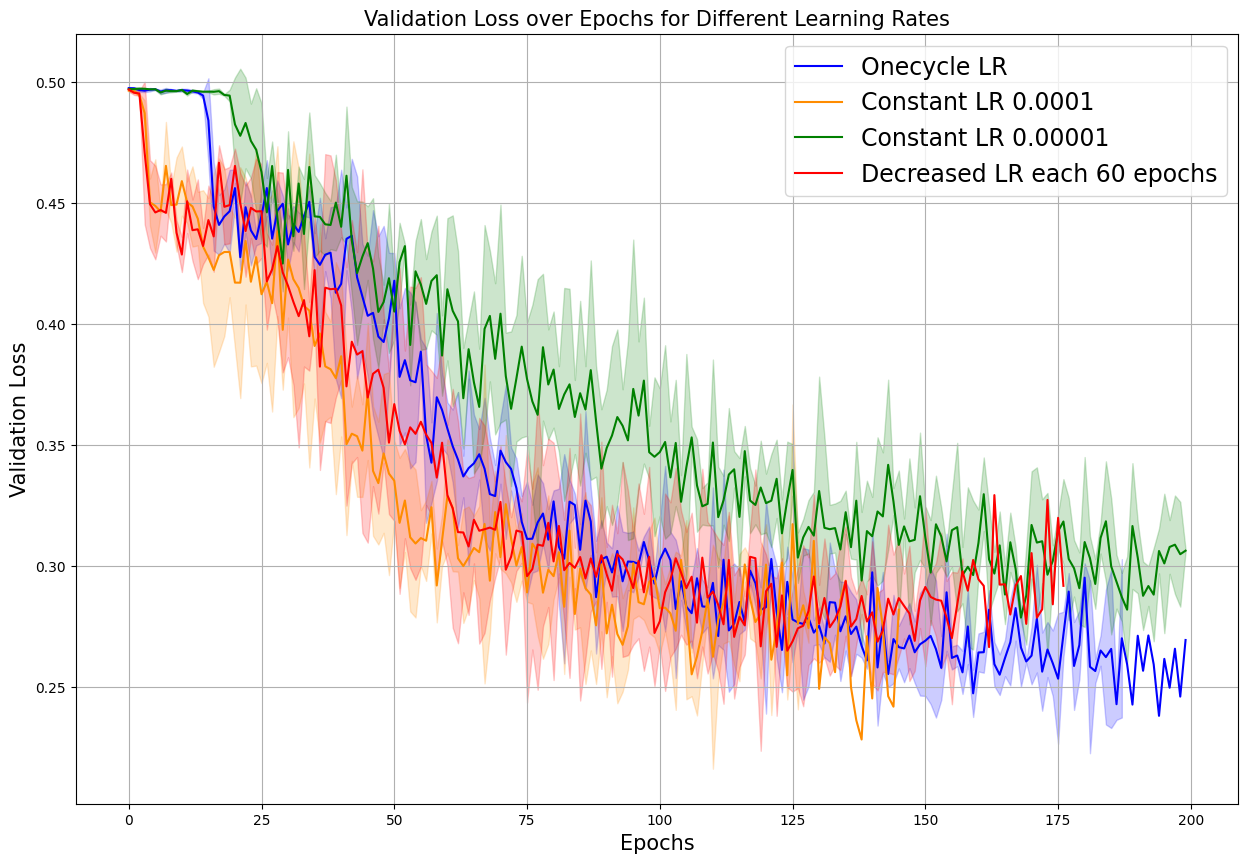

In [28]:
# Function to align dataframes on 'epoch' and calculate mean and std
def calculate_mean_std(dfs):
    aligned_df = pd.concat(dfs).groupby('epoch').mean().reset_index()
    aligned_std = pd.concat(dfs).groupby('epoch').std().reset_index()
    return aligned_df, aligned_std

# Calculate mean and std for each learning rate
onecycle_mean, onecycle_std = calculate_mean_std([onecycle_df, onecycle_df_1, onecycle_df_2])
const_0001_mean, const_0001_std = calculate_mean_std([const_0001_df, const_0001_df_1, const_0001_df_2])
const_00001_mean, const_00001_std = calculate_mean_std([const_00001_df, const_00001_df_1, const_00001_df_2])
decreased_60_mean, decreased_60_std = calculate_mean_std([decreased_60_df, decreased_60_df_1, decreased_60_df_2])

# Plotting the validation loss with shaded std areas
plt.figure(figsize=(15, 10))

plt.plot(onecycle_mean['epoch'], onecycle_mean['val_loss'], label='Onecycle LR', color='blue')
plt.fill_between(onecycle_mean['epoch'], onecycle_mean['val_loss'] - onecycle_std['val_loss'], onecycle_mean['val_loss'] + onecycle_std['val_loss'], alpha=0.2, color='blue')

plt.plot(const_0001_mean['epoch'], const_0001_mean['val_loss'], label='Constant LR 0.0001', color='darkorange')
plt.fill_between(const_0001_mean['epoch'], const_0001_mean['val_loss'] - const_0001_std['val_loss'], const_0001_mean['val_loss'] + const_0001_std['val_loss'], alpha=0.2, color='darkorange')

plt.plot(const_00001_mean['epoch'], const_00001_mean['val_loss'], label='Constant LR 0.00001', color='green')
plt.fill_between(const_00001_mean['epoch'], const_00001_mean['val_loss'] - const_00001_std['val_loss'], const_00001_mean['val_loss'] + const_00001_std['val_loss'], alpha=0.2, color='green')

plt.plot(decreased_60_mean['epoch'], decreased_60_mean['val_loss'], label='Decreased LR each 60 epochs', color='red')
plt.fill_between(decreased_60_mean['epoch'], decreased_60_mean['val_loss'] - decreased_60_std['val_loss'], decreased_60_mean['val_loss'] + decreased_60_std['val_loss'], alpha=0.2, color='red')

plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Validation Loss', fontsize=15)
plt.title('Validation Loss over Epochs for Different Learning Rates', fontsize=15)
plt.legend(fontsize=17)
plt.grid(True)
plt.show()

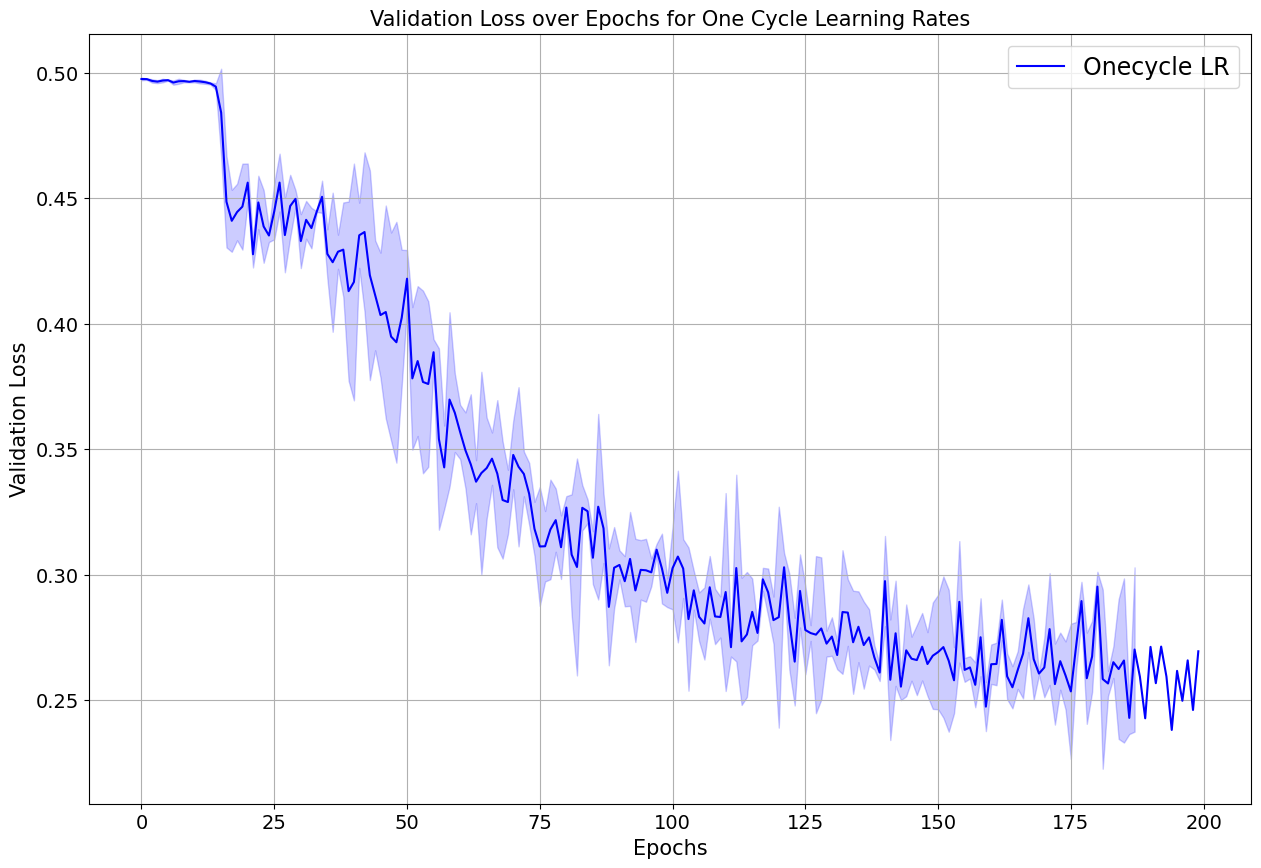

In [30]:
import matplotlib.pyplot as plt

# Plotting the validation loss with shaded std areas
plt.figure(figsize=(15, 10))

plt.plot(onecycle_mean['epoch'], onecycle_mean['val_loss'], label='Onecycle LR', color='blue')
plt.fill_between(onecycle_mean['epoch'], 
                 onecycle_mean['val_loss'] - onecycle_std['val_loss'], 
                 onecycle_mean['val_loss'] + onecycle_std['val_loss'], 
                 alpha=0.2, color='blue')


plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Validation Loss', fontsize=15)
plt.title('Validation Loss over Epochs for One Cycle Learning Rates', fontsize=15)
plt.legend(fontsize=17)

# Increase axis tick label size
plt.tick_params(axis='both', which='major', labelsize=14)  # Increase the size of tick labels
plt.grid(True)
plt.show()


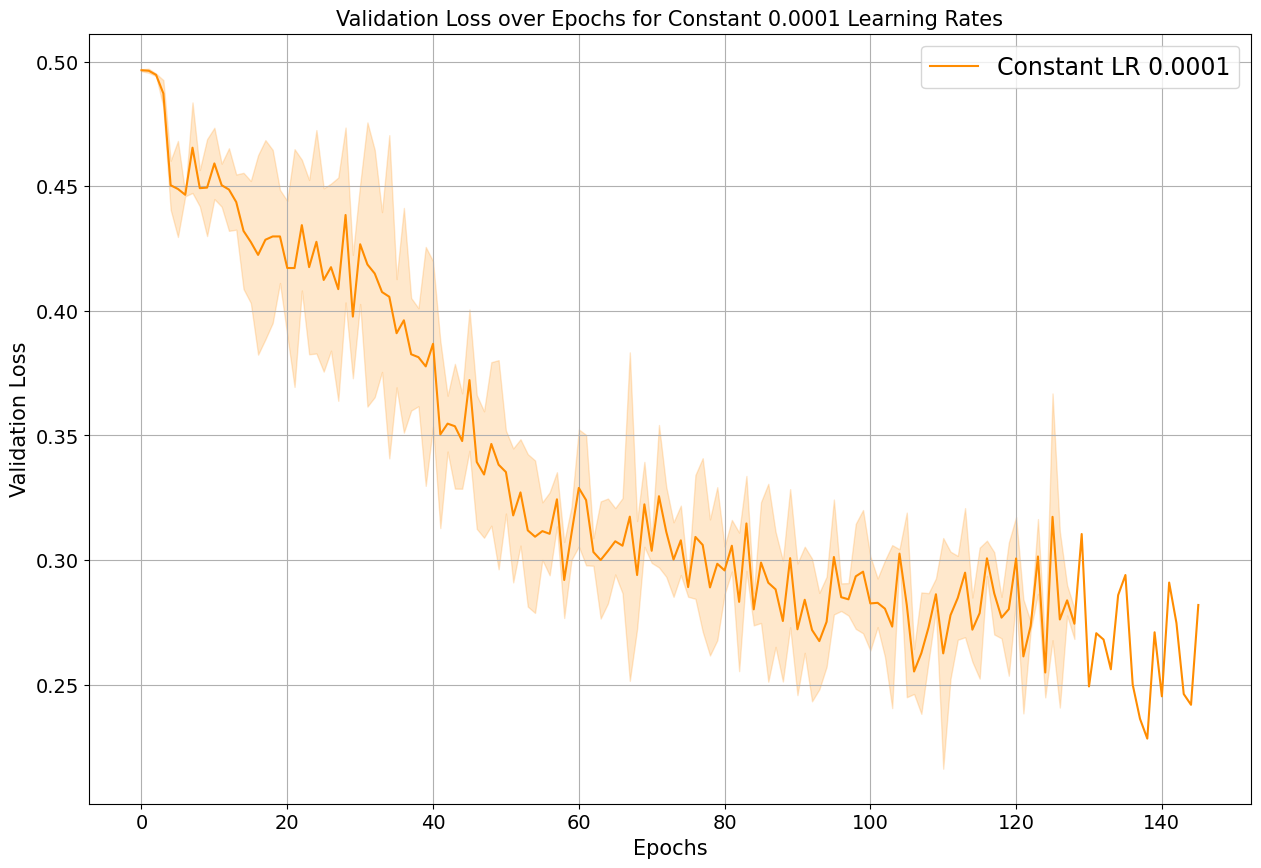

In [31]:
import matplotlib.pyplot as plt

# Plotting the validation loss with shaded std areas
plt.figure(figsize=(15, 10))


plt.plot(const_0001_mean['epoch'], const_0001_mean['val_loss'], label='Constant LR 0.0001', color='darkorange')
plt.fill_between(const_0001_mean['epoch'], 
                 const_0001_mean['val_loss'] - const_0001_std['val_loss'], 
                 const_0001_mean['val_loss'] + const_0001_std['val_loss'], 
                 alpha=0.2, color='darkorange')


plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Validation Loss', fontsize=15)
plt.title('Validation Loss over Epochs for Constant 0.0001 Learning Rates', fontsize=15)
plt.legend(fontsize=17)

# Increase axis tick label size
plt.tick_params(axis='both', which='major', labelsize=14)  # Increase the size of tick labels
plt.grid(True)
plt.show()


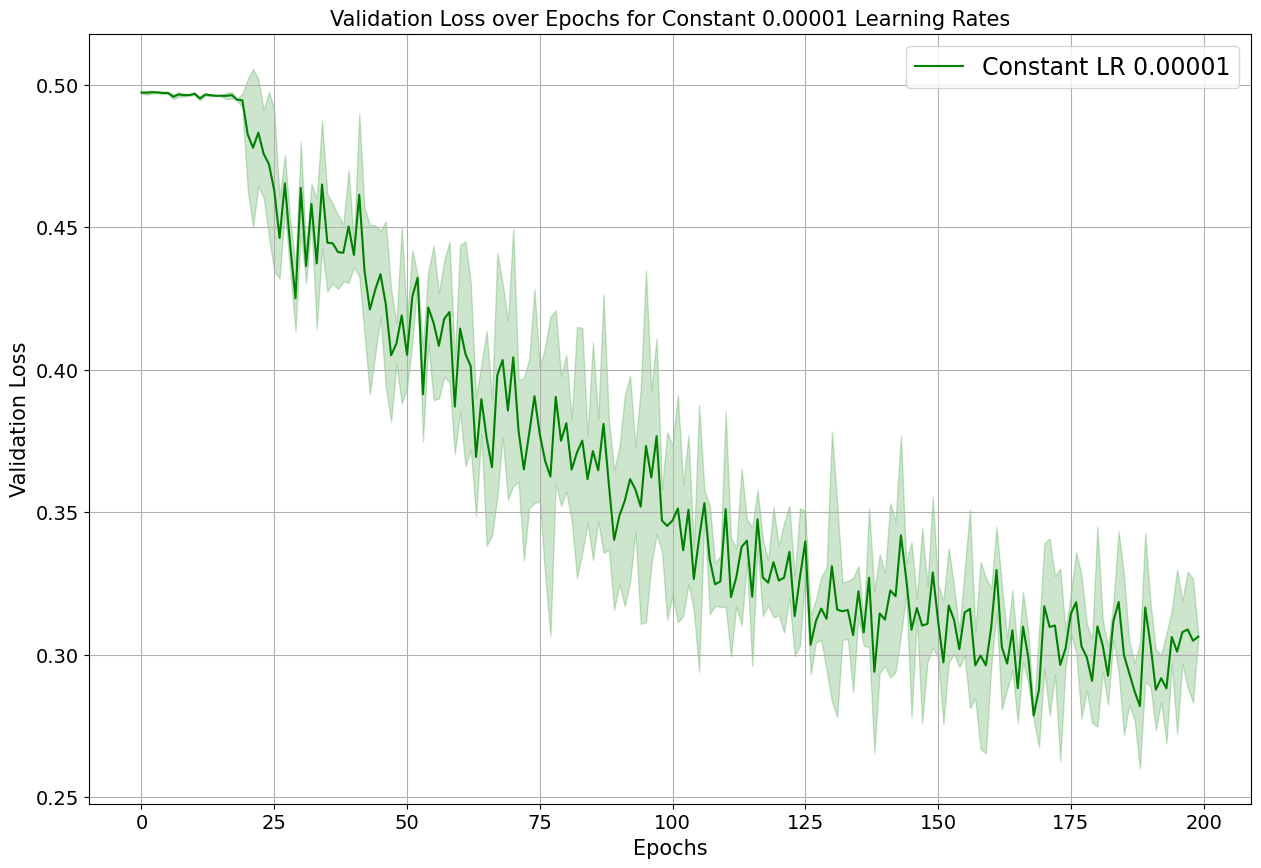

In [32]:
import matplotlib.pyplot as plt

# Plotting the validation loss with shaded std areas
plt.figure(figsize=(15, 10))

plt.plot(const_00001_mean['epoch'], const_00001_mean['val_loss'], label='Constant LR 0.00001', color='green')
plt.fill_between(const_00001_mean['epoch'], 
                 const_00001_mean['val_loss'] - const_00001_std['val_loss'], 
                 const_00001_mean['val_loss'] + const_00001_std['val_loss'], 
                 alpha=0.2, color='green')

plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Validation Loss', fontsize=15)
plt.title('Validation Loss over Epochs for Constant 0.00001 Learning Rates', fontsize=15)
plt.legend(fontsize=17)

# Increase axis tick label size
plt.tick_params(axis='both', which='major', labelsize=14)  # Increase the size of tick labels
plt.grid(True)
plt.show()


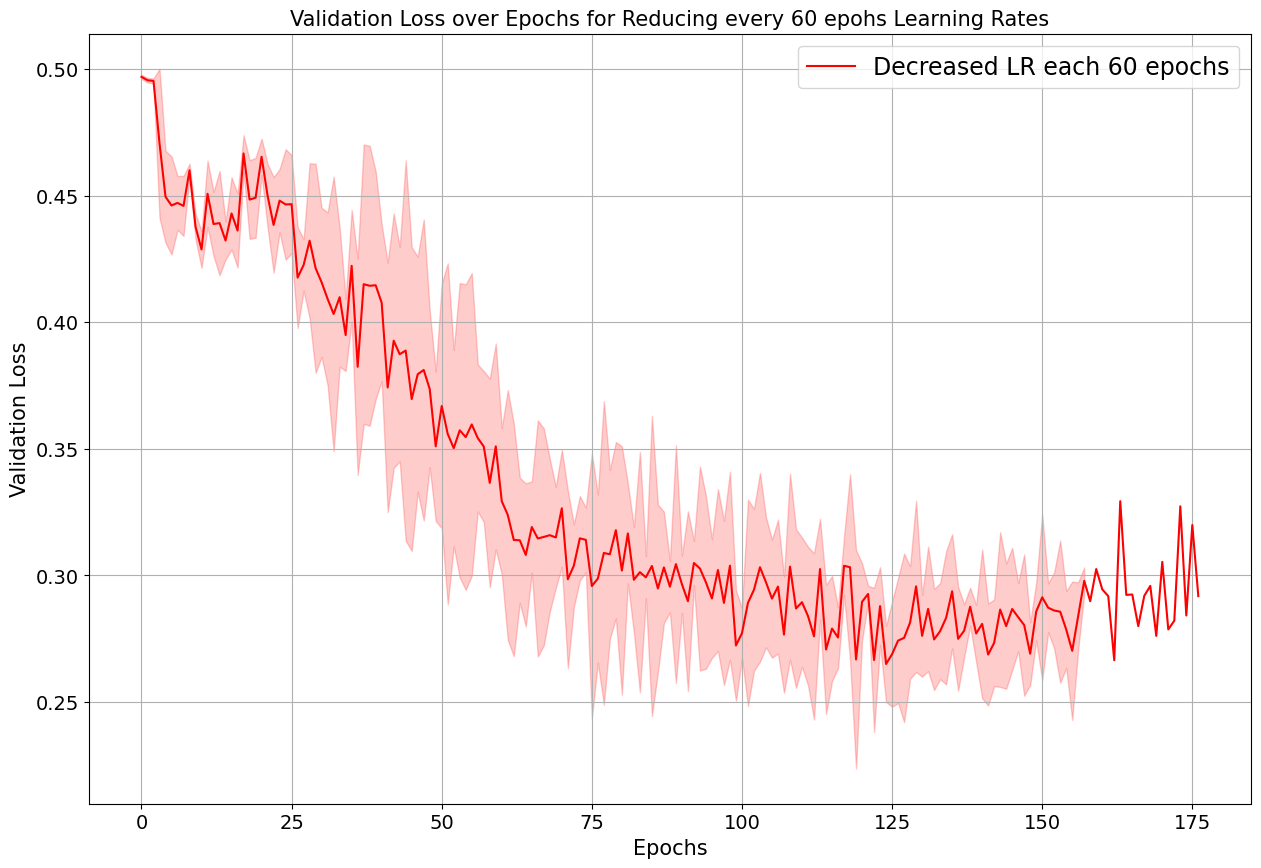

In [33]:


# Plotting the validation loss with shaded std areas
plt.figure(figsize=(15, 10))


plt.plot(decreased_60_mean['epoch'], decreased_60_mean['val_loss'], label='Decreased LR each 60 epochs', color='red')
plt.fill_between(decreased_60_mean['epoch'], decreased_60_mean['val_loss'] - decreased_60_std['val_loss'], decreased_60_mean['val_loss'] + decreased_60_std['val_loss'], alpha=0.2, color='red')

plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Validation Loss', fontsize=15)
plt.title('Validation Loss over Epochs for Reducing every 60 epohs Learning Rates', fontsize=15)
plt.legend(fontsize=17)
plt.tick_params(axis='both', which='major', labelsize=14)  # Increase the size of tick labels
plt.grid(True)
plt.show()

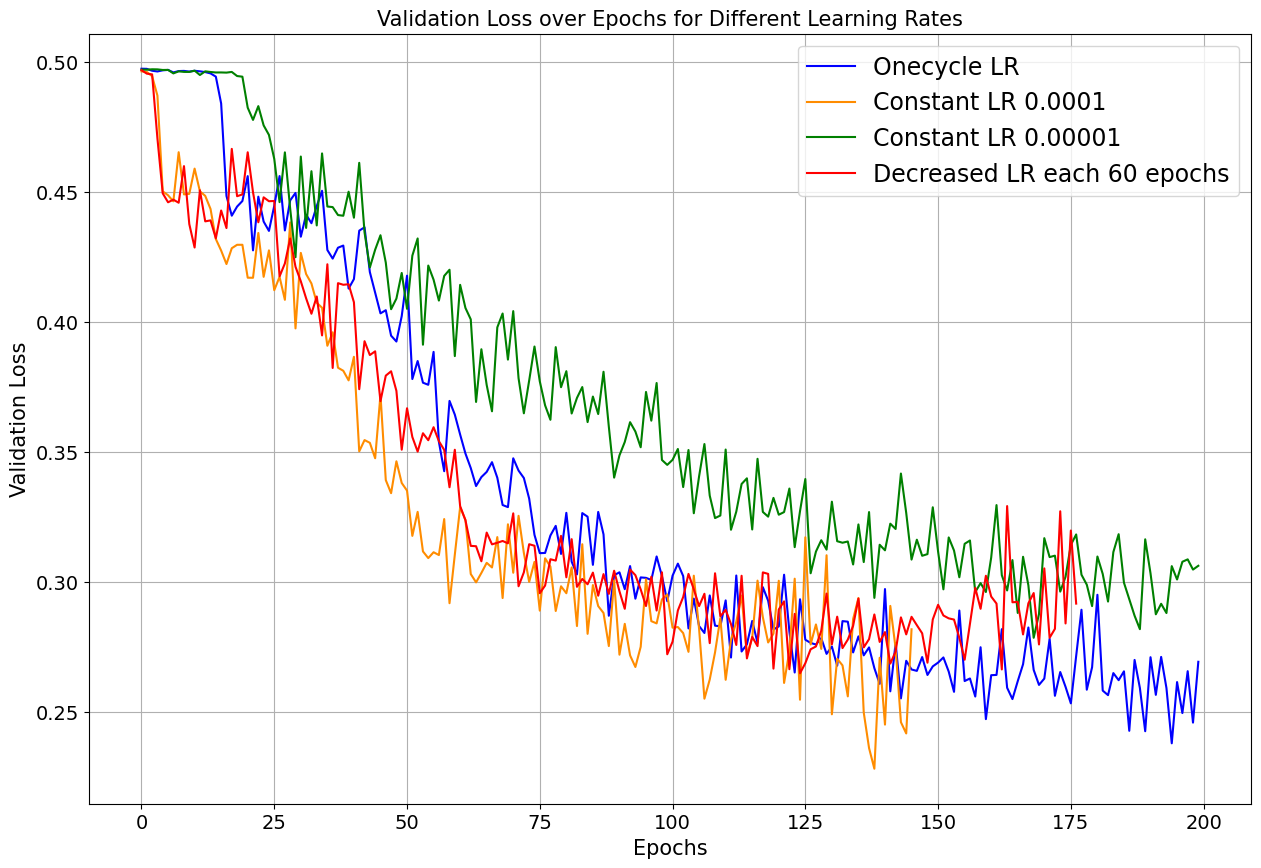

In [34]:
# Function to align dataframes on 'epoch' and calculate mean and std
def calculate_mean_std(dfs):
    aligned_df = pd.concat(dfs).groupby('epoch').mean().reset_index()
    aligned_std = pd.concat(dfs).groupby('epoch').std().reset_index()
    return aligned_df, aligned_std

# Calculate mean and std for each learning rate
onecycle_mean, onecycle_std = calculate_mean_std([onecycle_df, onecycle_df_1, onecycle_df_2])
const_0001_mean, const_0001_std = calculate_mean_std([const_0001_df, const_0001_df_1, const_0001_df_2])
const_00001_mean, const_00001_std = calculate_mean_std([const_00001_df, const_00001_df_1, const_00001_df_2])
decreased_60_mean, decreased_60_std = calculate_mean_std([decreased_60_df, decreased_60_df_1, decreased_60_df_2])

# Plotting the validation loss with shaded std areas
plt.figure(figsize=(15, 10))

plt.plot(onecycle_mean['epoch'], onecycle_mean['val_loss'], label='Onecycle LR', color='blue')
# plt.fill_between(onecycle_mean['epoch'], onecycle_mean['val_loss'] - onecycle_std['val_loss'], onecycle_mean['val_loss'] + onecycle_std['val_loss'], alpha=0.3, color='blue')

plt.plot(const_0001_mean['epoch'], const_0001_mean['val_loss'], label='Constant LR 0.0001', color='darkorange')
# plt.fill_between(const_0001_mean['epoch'], const_0001_mean['val_loss'] - const_0001_std['val_loss'], const_0001_mean['val_loss'] + const_0001_std['val_loss'], alpha=0.3, color='red')

plt.plot(const_00001_mean['epoch'], const_00001_mean['val_loss'], label='Constant LR 0.00001', color='green')
# plt.fill_between(const_00001_mean['epoch'], const_00001_mean['val_loss'] - const_00001_std['val_loss'], const_00001_mean['val_loss'] + const_00001_std['val_loss'], alpha=0.3, color='green')

plt.plot(decreased_60_mean['epoch'], decreased_60_mean['val_loss'], label='Decreased LR each 60 epochs', color='red')
# plt.fill_between(decreased_60_mean['epoch'], decreased_60_mean['val_loss'] - decreased_60_std['val_loss'], decreased_60_mean['val_loss'] + decreased_60_std['val_loss'], alpha=0.3, color='orange')


plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Validation Loss', fontsize=15)
plt.title('Validation Loss over Epochs for Different Learning Rates', fontsize=15)
plt.legend(fontsize=17)
plt.tick_params(axis='both', which='major', labelsize=14)  # Increase the size of tick labels
plt.grid(True)
plt.show()

In [49]:
const_0001_df

epoch  learning_rate  train_loss  val_loss
0        0         0.0001    0.496492  0.496590
1        1         0.0001    0.497233  0.495863
2        2         0.0001    0.495812  0.494427
3        3         0.0001    0.495573  0.489306
4        4         0.0001    0.467974  0.452630
..     ...            ...         ...       ...
141    141         0.0001    0.250230  0.290943
142    142         0.0001    0.276876  0.274708
143    143         0.0001    0.236685  0.246212
144    144         0.0001    0.243793  0.241883
145    145         0.0001    0.236390  0.281946

[146 rows x 4 columns]

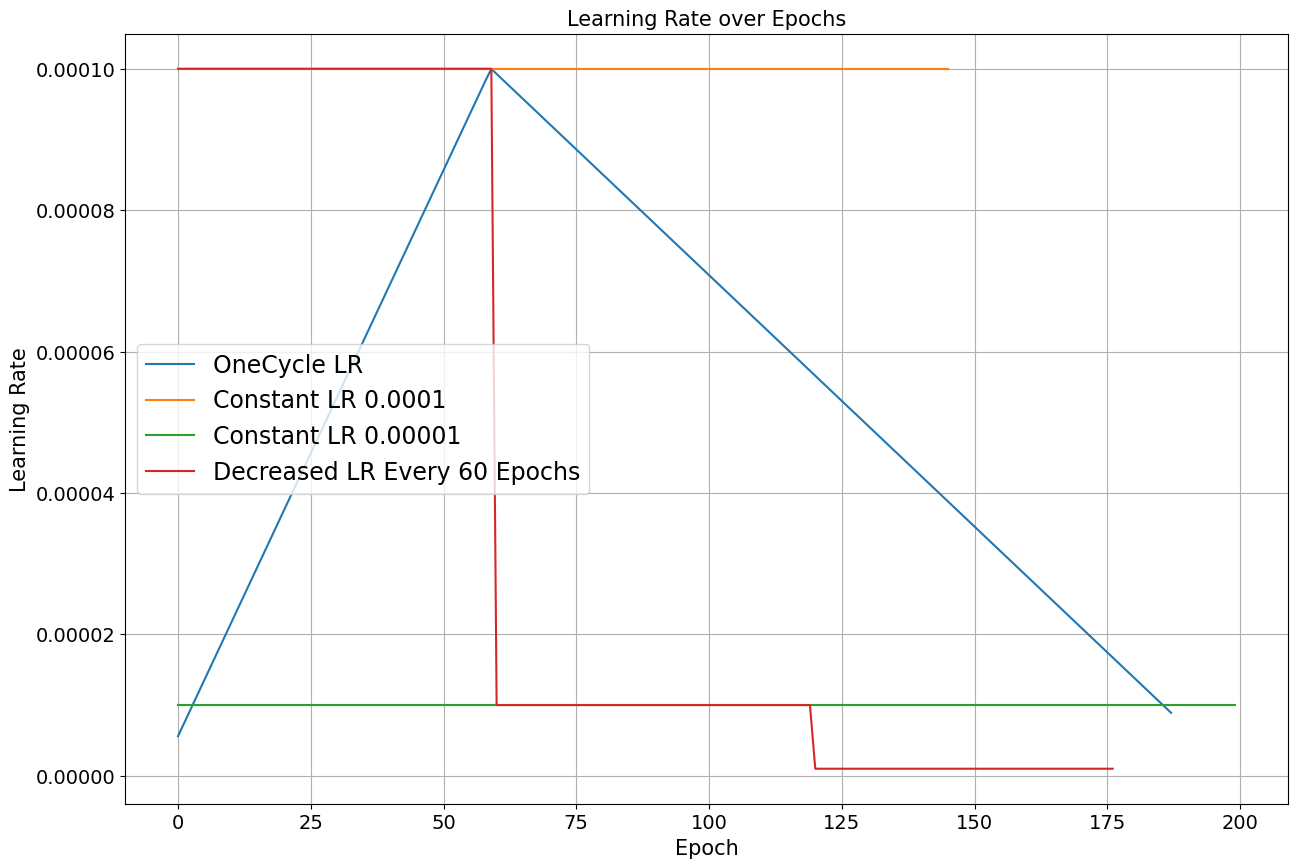

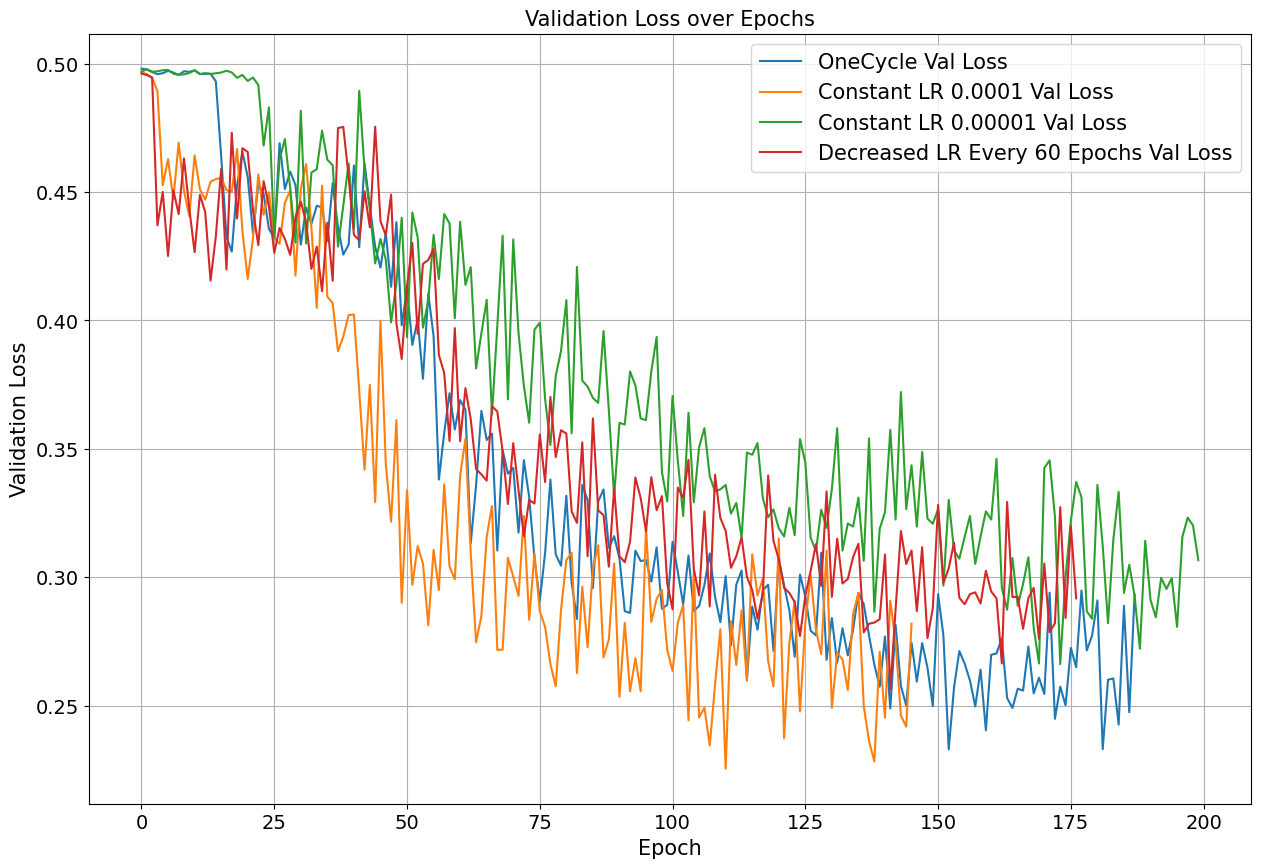

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming onecycle_df, const_0001_df, const_00001_df, and decreased_60_df are already defined

# Define the dataframes
onecycle_df = pd.read_csv(onecycle)
const_0001_df = pd.read_csv(const_0001)
const_00001_df = pd.read_csv(const_00001)
decreased_60_df = pd.read_csv(decreased_60)

# Plot learning rates over epochs
plt.figure(figsize=(15, 10))
plt.plot(onecycle_df['epoch'], onecycle_df['learning_rate'], label='OneCycle LR')
plt.plot(const_0001_df['epoch'], const_0001_df['learning_rate'], label='Constant LR 0.0001')
plt.plot(const_00001_df['epoch'], const_00001_df['learning_rate'], label='Constant LR 0.00001')
plt.plot(decreased_60_df['epoch'], decreased_60_df['learning_rate'], label='Decreased LR Every 60 Epochs')

plt.title('Learning Rate over Epochs', fontsize=15)
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Learning Rate', fontsize=15)
plt.legend(fontsize=17)
plt.tick_params(axis='both', which='major', labelsize=14)  # Increase the size of tick labels
plt.grid(True)
learning_rate_plot_path = os.path.join(models_save_path, 'learning_rate_plot.png')
# plt.savefig(learning_rate_plot_path)
plt.show()

# Plot validation loss over epochs
plt.figure(figsize=(15, 10))
plt.plot(onecycle_df['epoch'], onecycle_df['val_loss'], label='OneCycle Val Loss')
plt.plot(const_0001_df['epoch'], const_0001_df['val_loss'], label='Constant LR 0.0001 Val Loss')
plt.plot(const_00001_df['epoch'], const_00001_df['val_loss'], label='Constant LR 0.00001 Val Loss')
plt.plot(decreased_60_df['epoch'], decreased_60_df['val_loss'], label='Decreased LR Every 60 Epochs Val Loss')

plt.title('Validation Loss over Epochs', fontsize=15)
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Validation Loss', fontsize=15)
plt.legend(fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=14)  # Increase the size of tick labels
plt.grid(True)
# val_loss_plot_path = os.path.join(models_save_path, 'val_loss_plot.png')
# plt.savefig(val_loss_plot_path)
plt.show()

# print(f"Learning rate plot saved to {learning_rate_plot_path}")
# print(f"Validation loss plot saved to {val_loss_plot_path}")


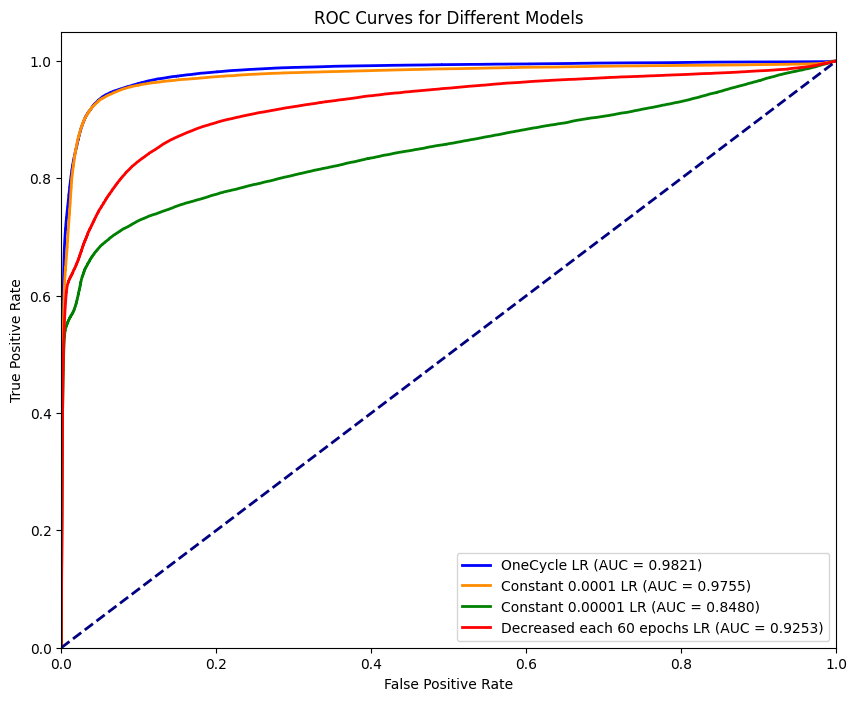

In [83]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np


# Function to calculate and plot ROC
def calculate_and_plot_ROC(labels, pred, label_name, color):
    fpr, tpr, _ = roc_curve(labels, pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, lw=2, label=f'{label_name} (AUC = {roc_auc:.4f})')
    return roc_auc

# Paths to the model files
model_paths = [
    'workspace/models/15_07_2024_BCE_dice_50_50_learning_rate_onecycle/model_2024-07-15_14-06-59.pth',
    'workspace/models/13_07_2024_BCE_dice_50_50_learning_rate_constant_0.0001/model_2024-07-13_14-09-19.pth',
    'workspace/models/14_07_2024_BCE_dice_50_50_learning_rate_constant_0.00001/model_2024-07-14_15-41-03.pth',
    'workspace/models/14_07_2024_BCE_dice_50_50_learning_rate_desrease_each_60/model_2024-07-14_21-02-55.pth'
]

# Colors for the ROC curves
colors = ['blue', 'darkorange', 'green', 'red']

# Load and evaluate each model
plt.figure(figsize=(10, 8))

for i, model_path in enumerate(model_paths):
    model = UNet(in_channels=1, out_channels=1)  # Adjust channels as necessary
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()

    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for batch_idx, (img, mask, weights, _, _, _) in enumerate(dataloader_test):
            img = img.to(device, dtype=torch.float)
            mask = mask.to(device, dtype=torch.float)
            output = model(img)
            predicted_probs = torch.sigmoid(output).cpu().numpy()
            all_predictions.append(predicted_probs)
            all_targets.append(mask.cpu().numpy())
    
    all_predictions = np.concatenate(all_predictions, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)

    labels = np.squeeze(np.array(all_targets, dtype=bool)).flatten()
    pred = np.squeeze(all_predictions).flatten()

    if i == 0:
        calculate_and_plot_ROC(labels, pred, f'OneCycle LR', colors[i])
    elif i == 1:
        calculate_and_plot_ROC(labels, pred, f'Constant 0.0001 LR', colors[i])
    elif i == 2:
        calculate_and_plot_ROC(labels, pred, f'Constant 0.00001 LR', colors[i])
    elif i == 3:
        calculate_and_plot_ROC(labels, pred, f'Decreased each 60 epochs LR', colors[i])

# Plot configuration
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Different Learning Rates")
plt.legend(loc="lower right")
plt.show()
